<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import tensorflow as tf
import sys
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
print('Python: %s'%(sys.version))
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
#print('pmdarima: %s'%(pmdarima.__version__))
#print('seaborn: %s'%(sns.__version__))
#print('statsmodel: %s'%(statsmodels.__version__))
print('matplotlib: %s'%(matplotlib.__version__))
print('tensorflow : %s'%( tf.__version__))

Python: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Numpy: 1.19.5
Pandas: 1.1.5
matplotlib: 3.2.2
tensorflow : 2.4.1


In [3]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [6]:
#df=pd.read_excel("BG_Dataset/BG_Sample55.xlsx")

In [7]:
file_name = "BG_Sample47"

In [8]:
# Colab
#df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_Dataset/"+file_name+".xlsx")
df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Dataset/BG_Sample46.csv")


In [9]:
df.shape

(2053, 14)

In [10]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형       환자 정보  \
0    1                        NaN     이름       NaN         sch   
1    2                        NaN      성       NaN           7   
2    3                        NaN   생년월일       NaN  1988-09-07   
3    4                        NaN     장치       NaN         NaN   
4    5                        NaN     경고        하락         NaN   
5    6                        NaN     경고        높음         NaN   
6    7                        NaN     경고        낮음         NaN   
7    8                        NaN     경고     신호 손실         NaN   
8    9                        NaN     경고        상승         NaN   
9   10                        NaN     경고   긴급하게 낮음         NaN   
10  11        2020-12-04T10:33:01    인슐린       NaN         NaN   
11  12        2020-12-04T12:08:07     교정       NaN         NaN   
12  13        2020-12-04T12:11:59     교정       NaN         NaN   

                   장치 정보 소스 장치 ID  포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN            NaN       NaN          NaN   
1                    NaN      NaN            NaN       NaN          NaN   
2                    NaN      NaN            NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android            NaN       NaN          NaN   
4                    NaN  Android            NaN       NaN          NaN   
5                    NaN  Android          400.0       NaN          NaN   
6                    NaN  Android           60.0       NaN          NaN   
7                    NaN  Android            NaN       NaN          NaN   
8                    NaN  Android            NaN       NaN          NaN   
9                    NaN  Android           55.0       NaN          NaN   
10                   NaN  Android            NaN       0.0          NaN   
11                   NaN  Android          166.0       NaN          NaN   
12                   NaN  Android          179.0       NaN          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7       0:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN      NaN  
11          NaN                  NaN               NaN   42J990  
12          NaN                  NaN               NaN   42J990

In [11]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [12]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [13]:
df['Event'].value_counts()

EGV     1979
탄수화물      24
인슐린       22
교정        18
경고         6
생년월일       1
성          1
이름         1
장치         1
Name: Event, dtype: int64

In [14]:
df['Glucose'].value_counts()

144.0    40
147.0    35
143.0    34
111.0    31
141.0    28
         ..
328.0     1
252.0     1
98.0      1
267.0     1
400.0     1
Name: Glucose, Length: 221, dtype: int64

In [15]:
df.tail()

Timestamp Event  Glucose  Insulin  Meal
2048  2020-12-11T08:50:22   EGV    178.0      NaN   NaN
2049  2020-12-11T08:55:22   EGV    174.0      NaN   NaN
2050  2020-12-11T09:00:22   EGV    171.0      NaN   NaN
2051  2020-12-11T09:05:22   EGV    169.0      NaN   NaN
2052  2020-12-11T09:10:22   EGV    166.0      NaN   NaN

In [16]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

0.0    22
Name: Insulin, dtype: int64

In [17]:
# 식사 횟수
df['Meal'].value_counts()

0.0    24
Name: Meal, dtype: int64

In [18]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0                   NaN    이름      NaN      NaN   NaN
1                   NaN     성      NaN      NaN   NaN
2                   NaN  생년월일      NaN      NaN   NaN
3                   NaN    장치      NaN      NaN   NaN
4                   NaN    경고      NaN      NaN   NaN
5                   NaN    경고    400.0      NaN   NaN
6                   NaN    경고     60.0      NaN   NaN
7                   NaN    경고      NaN      NaN   NaN
8                   NaN    경고      NaN      NaN   NaN
9                   NaN    경고     55.0      NaN   NaN
10  2020-12-04T10:33:01   인슐린      NaN      0.0   NaN
11  2020-12-04T12:08:07    교정    166.0      NaN   NaN
12  2020-12-04T12:11:59    교정    179.0      NaN   NaN
13  2020-12-04T12:15:42   EGV    165.0      NaN   NaN
14  2020-12-04T12:20:36   EGV    157.0      NaN   NaN

In [19]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [20]:
df.head(20)

Timestamp Event  Glucose  Insulin  Meal
10  2020-12-04T10:33:01   인슐린      NaN      0.0   NaN
11  2020-12-04T12:08:07    교정    166.0      NaN   NaN
12  2020-12-04T12:11:59    교정    179.0      NaN   NaN
13  2020-12-04T12:15:42   EGV    165.0      NaN   NaN
14  2020-12-04T12:20:36   EGV    157.0      NaN   NaN
15  2020-12-04T12:25:03  탄수화물      NaN      NaN   0.0
16  2020-12-04T12:25:03   인슐린      NaN      0.0   NaN
17  2020-12-04T12:25:37   EGV    147.0      NaN   NaN
18  2020-12-04T12:30:36   EGV    133.0      NaN   NaN
19  2020-12-04T12:35:37   EGV    125.0      NaN   NaN
20  2020-12-04T12:40:36   EGV    120.0      NaN   NaN
21  2020-12-04T12:45:36   EGV    127.0      NaN   NaN
22  2020-12-04T12:50:36   EGV    131.0      NaN   NaN
23  2020-12-04T12:55:37   EGV    131.0      NaN   NaN
24  2020-12-04T13:00:37   EGV    137.0      NaN   NaN
25  2020-12-04T13:05:37   EGV    145.0      NaN   NaN
26  2020-12-04T13:10:38   EGV    155.0      NaN   NaN
27  2020-12-04T13:15:37   EGV    171.0      NaN   NaN
28  2020-12-04T13:20:38   EGV    182.0      NaN   NaN
29  2020-12-04T13:25:38   EGV    190.0      NaN   NaN

In [21]:
df.shape

(2043, 5)

In [22]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [23]:
df.head(15)

Timestamp Event  Glucose  Insulin  Meal
0   2020-12-04T10:33:01   인슐린      NaN      0.0   NaN
1   2020-12-04T12:08:07    교정    166.0      NaN   NaN
2   2020-12-04T12:11:59    교정    179.0      NaN   NaN
3   2020-12-04T12:15:42   EGV    165.0      NaN   NaN
4   2020-12-04T12:20:36   EGV    157.0      NaN   NaN
5   2020-12-04T12:25:03  탄수화물      NaN      NaN   0.0
6   2020-12-04T12:25:03   인슐린      NaN      0.0   NaN
7   2020-12-04T12:25:37   EGV    147.0      NaN   NaN
8   2020-12-04T12:30:36   EGV    133.0      NaN   NaN
9   2020-12-04T12:35:37   EGV    125.0      NaN   NaN
10  2020-12-04T12:40:36   EGV    120.0      NaN   NaN
11  2020-12-04T12:45:36   EGV    127.0      NaN   NaN
12  2020-12-04T12:50:36   EGV    131.0      NaN   NaN
13  2020-12-04T12:55:37   EGV    131.0      NaN   NaN
14  2020-12-04T13:00:37   EGV    137.0      NaN   NaN

In [24]:
df.shape

(2043, 5)

In [25]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [26]:
def isNaN(num):
    return num==num

In [27]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [28]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [29]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [30]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [31]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [32]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [33]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [34]:
glucose_count_high(df,'Glucose')

높음 :  0


In [35]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [36]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [37]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [38]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [39]:
low_list

[]

In [40]:
calibration_count_low(df,'Event')

교정 :  18


In [41]:
calib_list

[1,
 2,
 50,
 226,
 429,
 501,
 707,
 813,
 998,
 1110,
 1295,
 1300,
 1419,
 1594,
 1695,
 1893,
 1896,
 1995]

In [42]:
insul_count(df,'Insulin')

인슐린 :  22


In [43]:
insulin_list

[0,
 6,
 232,
 278,
 297,
 360,
 409,
 533,
 595,
 658,
 704,
 827,
 957,
 1301,
 1420,
 1482,
 1546,
 1601,
 1722,
 1778,
 1848,
 2013]

In [44]:
meal_count(df,'Meal')

식사 횟수 :  24


In [45]:
meal_list

[5,
 69,
 235,
 300,
 370,
 534,
 596,
 663,
 849,
 895,
 956,
 990,
 1125,
 1153,
 1185,
 1260,
 1273,
 1456,
 1515,
 1551,
 1721,
 1781,
 1847,
 2024]

In [46]:
df['Insulin'].value_counts()

0.0    22
Name: Insulin, dtype: int64

In [47]:
df['Meal'].value_counts()

0.0    24
Name: Meal, dtype: int64

In [48]:
isNaN(df['Glucose'][14])

True

In [49]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [50]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [51]:
import math
math.isnan(df['Glucose'][14])

False

In [52]:
insulin_list

[0,
 6,
 232,
 278,
 297,
 360,
 409,
 533,
 595,
 658,
 704,
 827,
 957,
 1301,
 1420,
 1482,
 1546,
 1601,
 1722,
 1778,
 1848,
 2013]

In [53]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [54]:
insulin_list

[0,
 6,
 232,
 278,
 297,
 360,
 409,
 533,
 595,
 658,
 704,
 827,
 957,
 1301,
 1420,
 1482,
 1546,
 1601,
 1722,
 1778,
 1848,
 2013,
 1153,
 5,
 1551,
 534,
 663,
 1185,
 300,
 1456,
 1847,
 1721,
 956,
 69,
 849,
 596,
 990,
 1125,
 2024,
 235,
 1260,
 1515,
 370,
 1781,
 1273,
 895]

In [55]:
df=df.drop(insulin_list)

In [56]:
df[10:20]

Timestamp Event  Glucose  Insulin  Meal
13  2020-12-04T12:55:37   EGV    131.0      NaN   NaN
14  2020-12-04T13:00:37   EGV    137.0      NaN   NaN
15  2020-12-04T13:05:37   EGV    145.0      NaN   NaN
16  2020-12-04T13:10:38   EGV    155.0      NaN   NaN
17  2020-12-04T13:15:37   EGV    171.0      NaN   NaN
18  2020-12-04T13:20:38   EGV    182.0      NaN   NaN
19  2020-12-04T13:25:38   EGV    190.0      NaN   NaN
20  2020-12-04T13:30:38   EGV    196.0      NaN   NaN
21  2020-12-04T13:35:38   EGV    190.0      NaN   NaN
22  2020-12-04T13:40:38   EGV    183.0      NaN   NaN

In [57]:
df['Glucose'].unique()

array([166., 179., 165., 157., 147., 133., 125., 120., 127., 131., 137.,
       145., 155., 171., 182., 190., 196., 183., 169., 159., 163., 160.,
       154., 140., 136., 146., 149., 150., 148., 144., 158., 188., 187.,
       186., 178., 177., 172., 174., 175., 185., 167., 176., 195., 222.,
       239., 249., 255., 260., 251., 253., 263., 273., 261., 281., 296.,
       305., 307., 297., 285., 280., 278., 277., 309., 303., 292., 283.,
       286., 276., 269., 266., 248., 245., 242., 238., 234., 232., 229.,
       214., 209., 216., 217., 204., 191., 194., 180., 173., 156., 162.,
       164., 151., 143., 142., 153., 152., 170., 193., 184., 192., 197.,
       202., 206., 215., 223., 235., 205., 227., 226., 230., 233., 236.,
       298., 304., 313., 317., 320., 323., 311., 316., 300., 295., 289.,
       287., 294., 293., 291., 282., 264., 244., 218., 212., 208., 211.,
       213., 203., 200., 199., 219., 262., 272., 270., 254., 247., 241.,
       225., 221., 220., 210., 207., 198., 181., 24

In [58]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1975
Meal         1973
dtype: int64

In [59]:
df['Event'].value_counts()

EGV    1979
교정       18
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [60]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [61]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [62]:
fix_glucose_low(df,'Glucose')

In [63]:
fix_glucose(df,'Glucose')

In [64]:
df['Glucose'].value_counts()

144.0    40
147.0    35
143.0    34
111.0    31
141.0    28
         ..
278.0     1
308.0     1
311.0     1
336.0     1
333.0     1
Name: Glucose, Length: 218, dtype: int64

In [65]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1975
Meal         1973
dtype: int64

In [66]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [67]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [68]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [69]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [70]:
new_meal_list

[66,
 230,
 292,
 360,
 646,
 829,
 874,
 966,
 1100,
 1127,
 1158,
 1232,
 1244,
 1424,
 1481,
 1515,
 1740,
 1979]

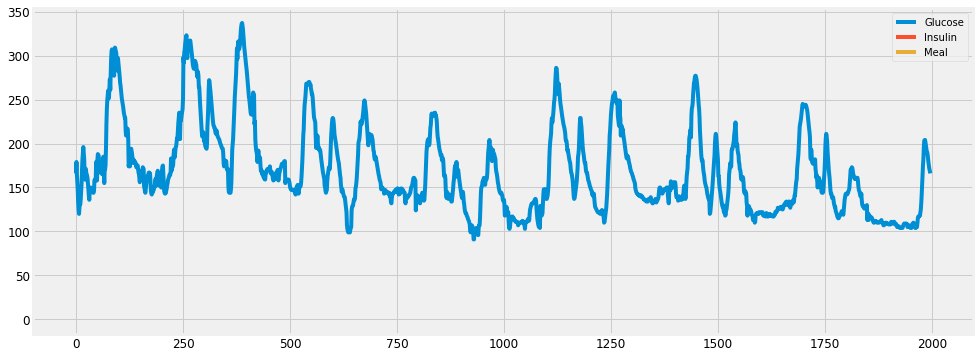

In [71]:
df.plot(figsize=(15,6))
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


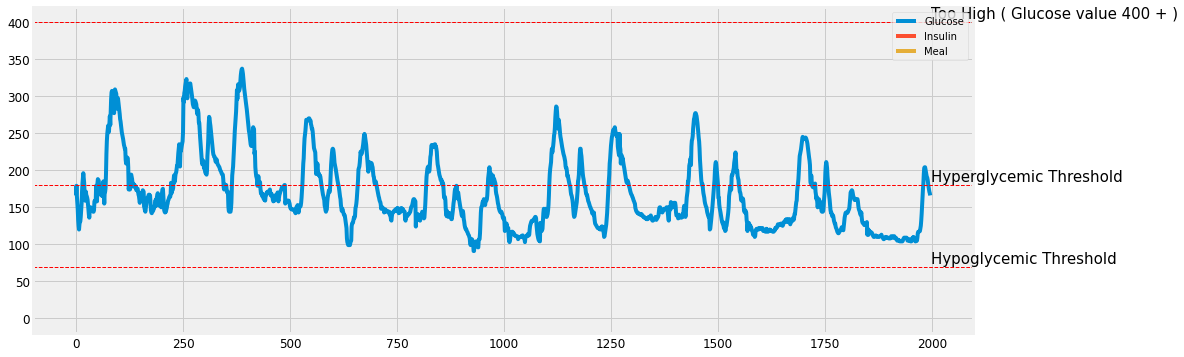

In [72]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [73]:
#df.drop(0,inplace=True)

In [74]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [75]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [76]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [77]:
#interpolate_glucose(df,'Glucose')

In [78]:
#meal

In [79]:
#insul

In [80]:
df['Glucose'].isnull().sum()

0

In [81]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [82]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [83]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [84]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


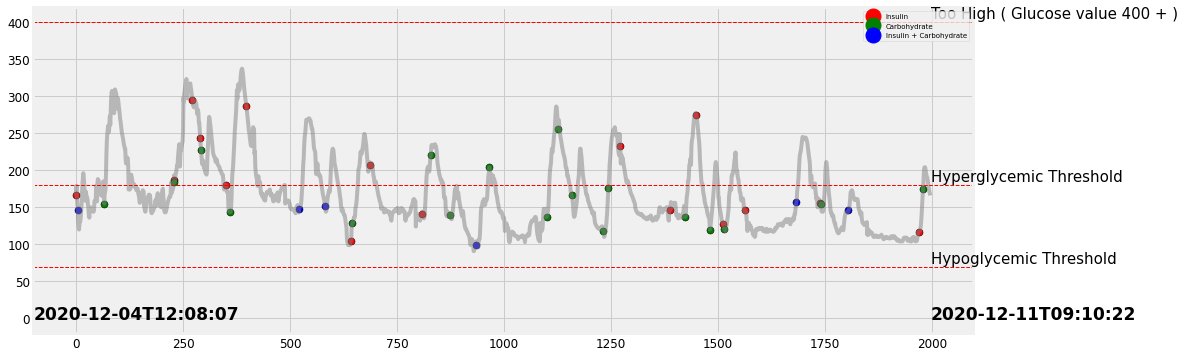

In [85]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [86]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [87]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [88]:
df[1900:1950]

Timestamp Event  Glucose  Insulin  Meal
1900  2020-12-11T01:15:22   EGV    108.0      0.0   0.0
1901  2020-12-11T01:20:22   EGV    108.0      0.0   0.0
1902  2020-12-11T01:25:22   EGV    108.0      0.0   0.0
1903  2020-12-11T01:30:21   EGV    108.0      0.0   0.0
1904  2020-12-11T01:35:21   EGV    110.0      0.0   0.0
1905  2020-12-11T01:40:20   EGV    111.0      0.0   0.0
1906  2020-12-11T01:45:21   EGV    110.0      0.0   0.0
1907  2020-12-11T01:50:21   EGV    109.0      0.0   0.0
1908  2020-12-11T01:55:21   EGV    109.0      0.0   0.0
1909  2020-12-11T02:00:21   EGV    110.0      0.0   0.0
1910  2020-12-11T02:05:22   EGV    111.0      0.0   0.0
1911  2020-12-11T02:10:21   EGV    111.0      0.0   0.0
1912  2020-12-11T02:15:22   EGV    111.0      0.0   0.0
1913  2020-12-11T02:20:22   EGV    109.0      0.0   0.0
1914  2020-12-11T02:25:21   EGV    108.0      0.0   0.0
1915  2020-12-11T02:30:20   EGV    109.0      0.0   0.0
1916  2020-12-11T02:35:22   EGV    108.0      0.0   0.0
1917  2020-12-11T02:40:22   EGV    108.0      0.0   0.0
1918  2020-12-11T02:45:23   EGV    106.0      0.0   0.0
1919  2020-12-11T02:50:23   EGV    105.0      0.0   0.0
1920  2020-12-11T02:55:22   EGV    106.0      0.0   0.0
1921  2020-12-11T03:00:22   EGV    106.0      0.0   0.0
1922  2020-12-11T03:05:23   EGV    106.0      0.0   0.0
1923  2020-12-11T03:10:22   EGV    105.0      0.0   0.0
1924  2020-12-11T03:15:22   EGV    105.0      0.0   0.0
1925  2020-12-11T03:20:22   EGV    104.0      0.0   0.0
1926  2020-12-11T03:25:22   EGV    104.0      0.0   0.0
1927  2020-12-11T03:30:23   EGV    104.0      0.0   0.0
1928  2020-12-11T03:35:22   EGV    104.0      0.0   0.0
1929  2020-12-11T03:40:22   EGV    104.0      0.0   0.0
1930  2020-12-11T03:45:22   EGV    104.0      0.0   0.0
1931  2020-12-11T03:50:23   EGV    104.0      0.0   0.0
1932  2020-12-11T03:55:22   EGV    105.0      0.0   0.0
1933  2020-12-11T04:00:22   EGV    107.0      0.0   0.0
1934  2020-12-11T04:05:22   EGV    108.0      0.0   0.0
1935  2020-12-11T04:10:22   EGV    109.0      0.0   0.0
1936  2020-12-11T04:15:22   EGV    109.0      0.0   0.0
1937  2020-12-11T04:20:23   EGV    109.0      0.0   0.0
1938  2020-12-11T04:25:22   EGV    109.0      0.0   0.0
1939  2020-12-11T04:30:23   EGV    109.0      0.0   0.0
1940  2020-12-11T04:35:22   EGV    109.0      0.0   0.0
1941  2020-12-11T04:40:23   EGV    109.0      0.0   0.0
1942  2020-12-11T04:45:23   EGV    107.0      0.0   0.0
1943  2020-12-11T04:50:23   EGV    105.0      0.0   0.0
1944  2020-12-11T04:55:23   EGV    105.0      0.0   0.0
1945  2020-12-11T05:00:24   EGV    105.0      0.0   0.0
1946  2020-12-11T05:05:23   EGV    106.0      0.0   0.0
1947  2020-12-11T05:10:23   EGV    107.0      0.0   0.0
1948  2020-12-11T05:15:23   EGV    105.0      0.0   0.0
1949  2020-12-11T05:20:23   EGV    105.0      0.0   0.0

In [89]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [90]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [91]:
import numpy as np
import tensorflow as tf
import random as rn

In [92]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [93]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [94]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [95]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [96]:
leaky_relu = tf.nn.leaky_relu

In [97]:
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print ("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print ("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

## 15분

In [98]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [99]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

In [100]:
len(raw_seq) * 0.7

1397.8999999999999

In [101]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [102]:
# SG필터 적용하는 부분 
# x_train_uni_origin 이런 식이었음 
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=2 # 이거 -1이면 naive method 
#x_train_uni,y_train_uni = uni_data(,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)

In [103]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [104]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [105]:
y_val_uni.shape

(592,)

In [106]:
y_train_uni.shape

(1391,)

In [107]:
#y_train_uni_origin[:10]

In [108]:
#y_train_uni.shape
df[:15]

Timestamp Event  Glucose  Insulin  Meal
0   2020-12-04T12:08:07    교정    166.0      1.0   0.0
1   2020-12-04T12:11:59    교정    179.0      0.0   0.0
2   2020-12-04T12:15:42   EGV    165.0      0.0   0.0
3   2020-12-04T12:20:36   EGV    157.0      0.0   0.0
4   2020-12-04T12:25:37   EGV    147.0      1.0   1.0
5   2020-12-04T12:30:36   EGV    133.0      0.0   0.0
6   2020-12-04T12:35:37   EGV    125.0      0.0   0.0
7   2020-12-04T12:40:36   EGV    120.0      0.0   0.0
8   2020-12-04T12:45:36   EGV    127.0      0.0   0.0
9   2020-12-04T12:50:36   EGV    131.0      0.0   0.0
10  2020-12-04T12:55:37   EGV    131.0      0.0   0.0
11  2020-12-04T13:00:37   EGV    137.0      0.0   0.0
12  2020-12-04T13:05:37   EGV    145.0      0.0   0.0
13  2020-12-04T13:10:38   EGV    155.0      0.0   0.0
14  2020-12-04T13:15:37   EGV    171.0      0.0   0.0

In [109]:
x_train_uni[5:10]

array([[[133],
        [125],
        [120],
        [127],
        [131],
        [131]],

       [[125],
        [120],
        [127],
        [131],
        [131],
        [137]],

       [[120],
        [127],
        [131],
        [131],
        [137],
        [145]],

       [[127],
        [131],
        [131],
        [137],
        [145],
        [155]],

       [[131],
        [131],
        [137],
        [145],
        [155],
        [171]]])

In [110]:
y_train_uni[5:10]

array([155, 171, 182, 190, 196])

In [111]:
#df['Glucose'].head(10)

In [112]:
x_train_uni.shape[-2:]

(6, 1)

### RNN - 15분

In [113]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [114]:
from keras.layers import SimpleRNN

In [115]:
#n_steps = 3
#delay=3
#n_features=1

In [116]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [117]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False)) #recurrent_dropout=0.2
model.add(Dense(1))

In [118]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()


In [119]:
val_rnn_15_predict_result = model.predict(x_val_uni,verbose=0)

In [120]:
# 예측값 상한선 = 400 
for i in range(len(val_rnn_15_predict_result)):
    if val_rnn_15_predict_result[i] >= 400: 
        val_rnn_15_predict_result[i]=400
    elif val_rnn_15_predict_result[i] <=60:
      val_rnn_15_predict_result[i] = 60
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,val_rnn_15_predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,val_rnn_15_predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  8.722384335999383


In [121]:
get_x_train_origin_15 = np.array(y_train_uni_origin)

In [122]:
get_x_train_origin_15 = get_x_train_origin_15.reshape(1,len(y_train_uni_origin))

In [123]:
get_x_train_origin_15.shape

(1, 1391)

In [124]:
get_y_val_origin_15 = np.array(y_val_uni_origin)

In [125]:
get_y_val_origin_15 = get_y_val_origin_15.reshape(1,len(get_y_val_origin_15))

In [126]:
get_y_val_origin_15.shape

(1, 592)

In [127]:
#get_y_val_origin

In [128]:
get_val_rnn_15_predict_result = np.array(val_rnn_15_predict_result)

In [129]:
get_val_rnn_15_predict_result = get_val_rnn_15_predict_result.T

In [130]:
get_val_rnn_15_predict_result.shape

(1, 592)

In [131]:
#ar_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result), axis = 0)


In [132]:
#y=pd.DataFrame(ar,index=['15_val_origin','15_rnn'])
#y
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

In [133]:
#get_val_rnn_15_pedict_result =get_val_rnn_15_pedict_result.reshape(1,len(get_val_rnn_15_pedict_result))

In [134]:
get_val_rnn_15_predict_result.shape

(1, 592)

#### Validation

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


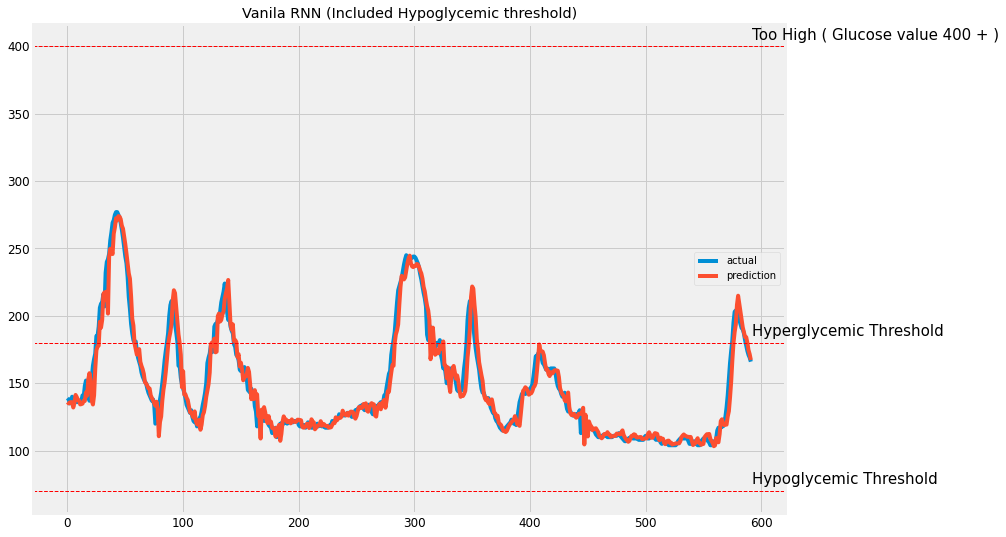

In [135]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [136]:
val_rnn_15_predict_result

array([[135.99333 ],
       [135.02654 ],
       [135.70903 ],
       [136.02345 ],
       [135.82054 ],
       [131.9955  ],
       [135.24825 ],
       [141.32008 ],
       [139.79233 ],
       [137.5931  ],
       [137.11914 ],
       [134.29872 ],
       [134.49634 ],
       [134.88924 ],
       [137.03532 ],
       [136.8998  ],
       [143.18593 ],
       [140.80986 ],
       [152.98317 ],
       [157.44395 ],
       [152.08484 ],
       [136.90918 ],
       [134.21663 ],
       [141.04968 ],
       [160.4775  ],
       [174.4592  ],
       [177.18137 ],
       [177.96208 ],
       [195.64104 ],
       [191.27032 ],
       [196.99004 ],
       [216.05663 ],
       [217.49498 ],
       [211.64558 ],
       [217.95396 ],
       [201.69467 ],
       [243.6835  ],
       [249.81677 ],
       [248.11398 ],
       [245.85992 ],
       [260.9411  ],
       [265.6351  ],
       [272.45465 ],
       [270.8889  ],
       [273.9848  ],
       [273.6889  ],
       [271.79495 ],
       [266.8

In [137]:
len(val_rnn_15_predict_result)

592

In [138]:
y_val_uni_origin

array([139, 138, 135, 136, 140, 139, 138, 138, 136, 136, 136, 137, 137,
       141, 140, 148, 152, 150, 142, 137, 141, 154, 163, 168, 172, 185,
       185, 192, 206, 209, 210, 216, 207, 232, 240, 242, 246, 256, 262,
       269, 271, 275, 277, 277, 275, 273, 269, 264, 258, 251, 244, 239,
       229, 214, 205, 194, 187, 182, 180, 181, 174, 169, 166, 163, 158,
       155, 153, 151, 150, 146, 143, 141, 139, 137, 138, 134, 120, 121,
       126, 132, 138, 143, 150, 158, 167, 174, 180, 187, 200, 208, 211,
       208, 202, 194, 188, 181, 163, 163, 154, 149, 146, 143, 139, 134,
       132, 130, 128, 130, 125, 122, 121, 123, 118, 119, 124, 125, 129,
       134, 138, 143, 150, 165, 169, 172, 178, 173, 174, 192, 194, 194,
       197, 200, 203, 210, 214, 218, 224, 215, 203, 197, 199, 192, 189,
       187, 179, 177, 171, 170, 167, 160, 159, 159, 159, 162, 160, 154,
       145, 144, 143, 146, 143, 143, 133, 129, 118, 127, 126, 129, 128,
       124, 122, 125, 122, 122, 119, 118, 117, 113, 116, 115, 11

In [139]:
## test 


In [140]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

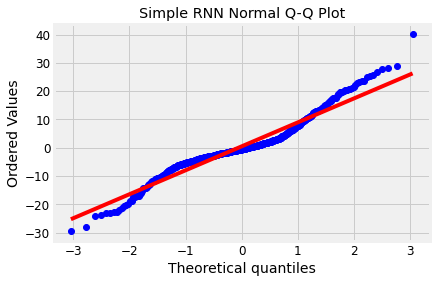

In [141]:
residuals = [y_val_uni_origin[i]-val_rnn_15_predict_result[i] for i in range(len(val_rnn_15_predict_result))]
residuals = y_val_uni_origin - val_rnn_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

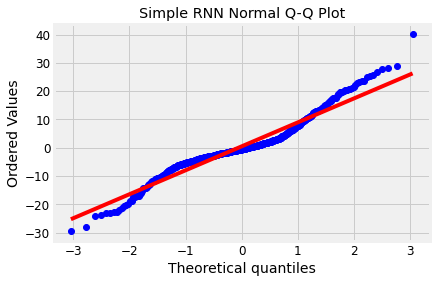

In [142]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [143]:
residuals=DataFrame(residuals)

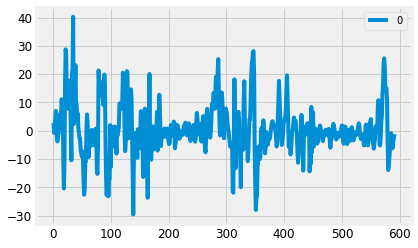

In [144]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbfb221490>]],
      dtype=object)

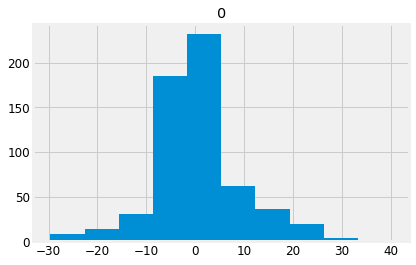

In [145]:

residuals.hist()

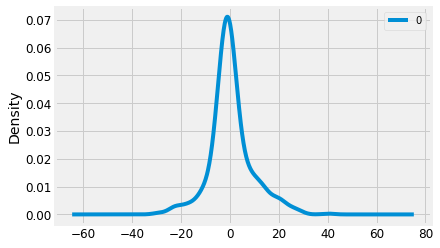

In [146]:
residuals.plot(kind='kde')

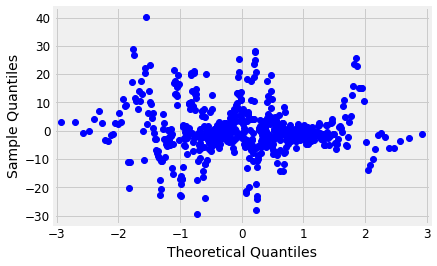

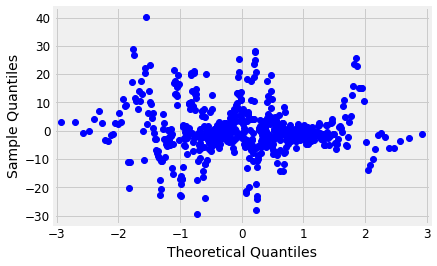

In [147]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [148]:
# 트레이닝셋 rmse 구하는 부분 
train_rnn_15_predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(train_rnn_15_predict_result)):
    if train_rnn_15_predict_result[i] >= 400: 
        train_rnn_15_predict_result[i]=400  
    elif train_rnn_15_predict_result[i] <= 60: 
        train_rnn_15_predict_result[i]=60             
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,train_rnn_15_predict_result))
train_rnn_15=RMSE(y_train_uni_origin,train_rnn_15_predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  11.834638754966225


In [149]:
get_train_rnn_15_predict_result = np.array(train_rnn_15_predict_result)

In [150]:
get_train_rnn_15_predict_result = get_train_rnn_15_predict_result.T

In [151]:
get_train_rnn_15_predict_result.shape

(1, 1391)

#### Train

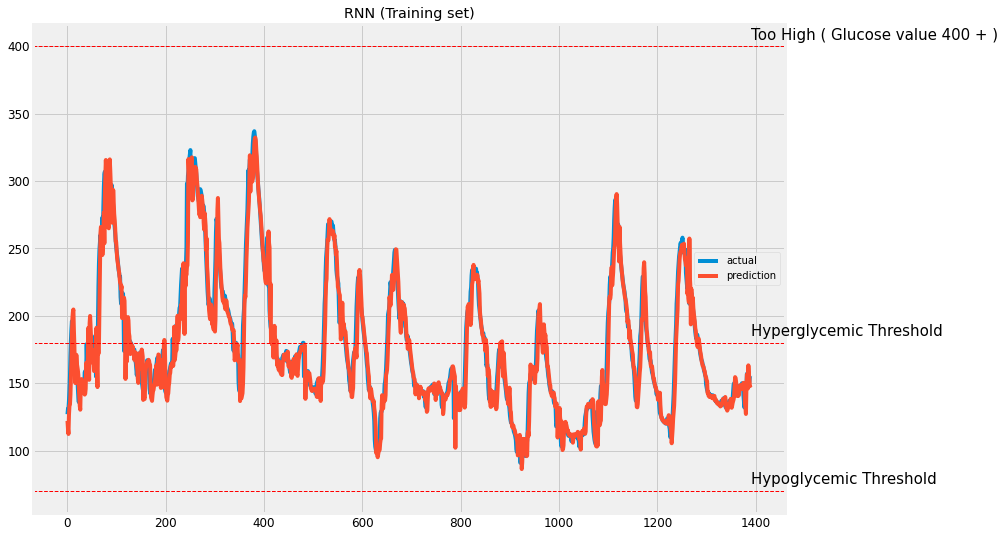

In [152]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

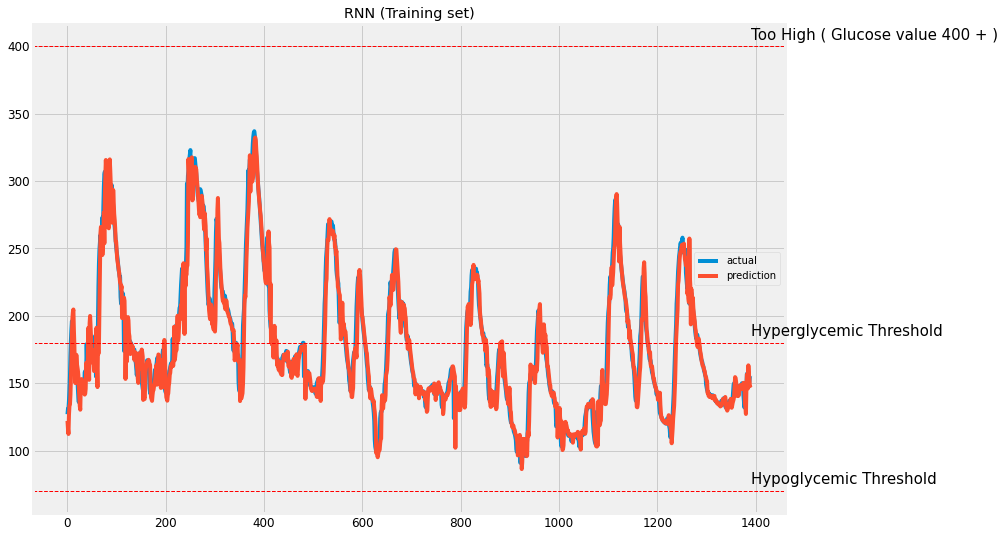

In [153]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [154]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [155]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:])) #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


In [156]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()
val_lstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [157]:
# 예측값 상한선 = 400 
for i in range(len(val_lstm_15_predict_result)):
    if val_lstm_15_predict_result[i] >= 400: 
        val_lstm_15_predict_result[i]=400
    if val_lstm_15_predict_result[i] <= 60: 
        val_lstm_15_predict_result[i]=60
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,val_lstm_15_predict_result))
val_lstm_15=RMSE(y_val_uni_origin,val_lstm_15_predict_result)

 LSTM - RMSE (15min) :  9.190385701216298


In [158]:
get_val_lstm_15_predict_result = np.array(val_lstm_15_predict_result)

In [159]:
get_val_lstm_15_predict_result = get_val_lstm_15_predict_result.T

In [160]:
get_val_lstm_15_predict_result.shape

(1, 592)

In [161]:
val_lstm_15_predict_result

array([[139.70926 ],
       [138.19247 ],
       [138.83957 ],
       [138.1869  ],
       [136.75539 ],
       [133.34851 ],
       [135.74457 ],
       [140.94724 ],
       [138.07808 ],
       [137.03635 ],
       [137.39479 ],
       [134.60574 ],
       [135.37575 ],
       [135.31549 ],
       [136.71738 ],
       [136.33412 ],
       [142.57857 ],
       [139.27524 ],
       [152.82405 ],
       [156.11584 ],
       [149.94939 ],
       [139.08641 ],
       [135.21704 ],
       [141.0398  ],
       [158.86272 ],
       [174.18427 ],
       [179.27867 ],
       [181.24863 ],
       [202.31758 ],
       [189.25647 ],
       [199.65535 ],
       [223.23878 ],
       [215.87315 ],
       [209.62729 ],
       [218.2728  ],
       [201.38072 ],
       [240.84041 ],
       [249.0355  ],
       [245.36784 ],
       [245.1394  ],
       [262.76834 ],
       [260.65433 ],
       [268.75845 ],
       [265.02225 ],
       [268.51163 ],
       [267.47137 ],
       [266.3966  ],
       [265.2

In [162]:
TRAIN_SPLIT

1397

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

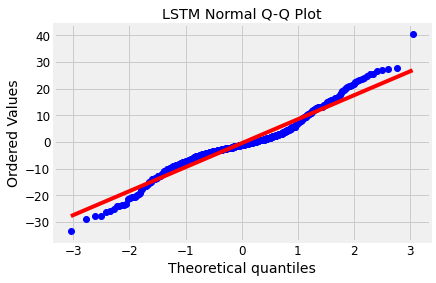

In [163]:
residuals = [y_val_uni_origin[i]-val_lstm_15_predict_result[i] for i in range(len(val_lstm_15_predict_result))]
residuals = y_val_uni_origin - val_lstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

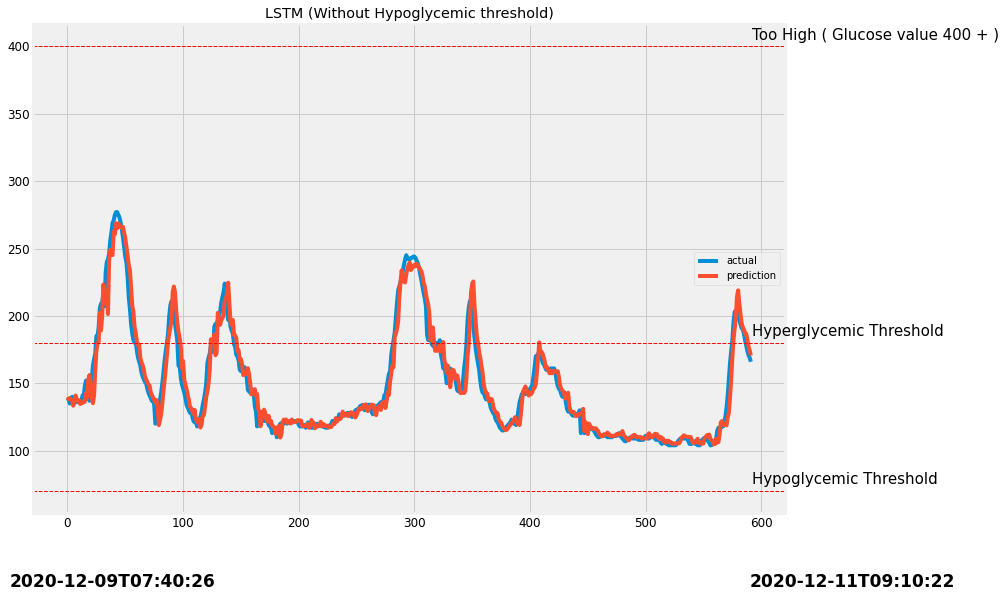

In [164]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [165]:
# 트레이닝셋 RMSE 계산 
train_lstm_15_predict_result = model.predict(x_train_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(train_lstm_15_predict_result)):
    if train_lstm_15_predict_result[i] >= 400: 
        train_lstm_15_predict_result[i]=400
    elif train_lstm_15_predict_result[i] <= 60: 
        train_lstm_15_predict_result[i]=60
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_lstm_15_predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,train_lstm_15_predict_result)

 LSTM - RMSE (15min) Training set :  11.572837600596884


In [166]:
get_train_lstm_15_predict_result = np.array(train_lstm_15_predict_result)

In [167]:
get_train_lstm_15_predict_result = get_train_lstm_15_predict_result.T

In [168]:
get_train_lstm_15_predict_result.shape

(1, 1391)

#### Train

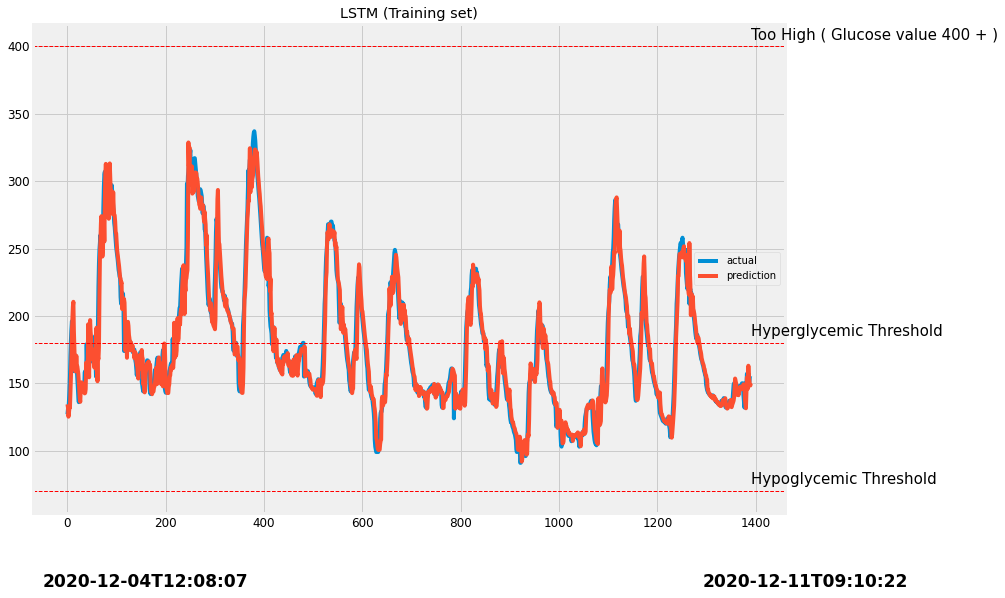

In [169]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_lstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [170]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [171]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [172]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [173]:
K.clear_session()

In [174]:
val_slstm_15_predict_result = model.predict(x_val_uni,verbose=0)


In [175]:
for i in range(len(val_slstm_15_predict_result)):
    if val_slstm_15_predict_result[i] >= 400: 
        val_slstm_15_predict_result[i]=400
    elif val_slstm_15_predict_result[i] <= 60: 
        val_slstm_15_predict_result[i]=60

In [176]:
get_val_slstm_15_predict_result = np.array(val_slstm_15_predict_result)

In [177]:
get_val_slstm_15_predict_result = get_val_slstm_15_predict_result.T

In [178]:
get_val_slstm_15_predict_result.shape

(1, 592)

In [179]:
val_slstm_15_predict_result

array([[139.1587  ],
       [136.9478  ],
       [136.9598  ],
       [136.7677  ],
       [134.94142 ],
       [131.34608 ],
       [135.06984 ],
       [143.23119 ],
       [137.08638 ],
       [135.8692  ],
       [136.89098 ],
       [133.08574 ],
       [134.45549 ],
       [134.50648 ],
       [136.92932 ],
       [135.65866 ],
       [145.28185 ],
       [137.81087 ],
       [156.23656 ],
       [153.96349 ],
       [147.70448 ],
       [137.61586 ],
       [134.00993 ],
       [140.30673 ],
       [167.27861 ],
       [173.5967  ],
       [173.04897 ],
       [177.90096 ],
       [207.42278 ],
       [179.99577 ],
       [206.32076 ],
       [226.07162 ],
       [204.32542 ],
       [205.67172 ],
       [227.32164 ],
       [203.53825 ],
       [222.15031 ],
       [236.93425 ],
       [231.25433 ],
       [247.22289 ],
       [268.63922 ],
       [259.63913 ],
       [272.33194 ],
       [260.85214 ],
       [277.15335 ],
       [271.6279  ],
       [268.1636  ],
       [263.9

In [180]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,val_slstm_15_predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,val_slstm_15_predict_result)

 Stacked LSTM - RMSE(15min) :  8.78242739822535


#### Validation

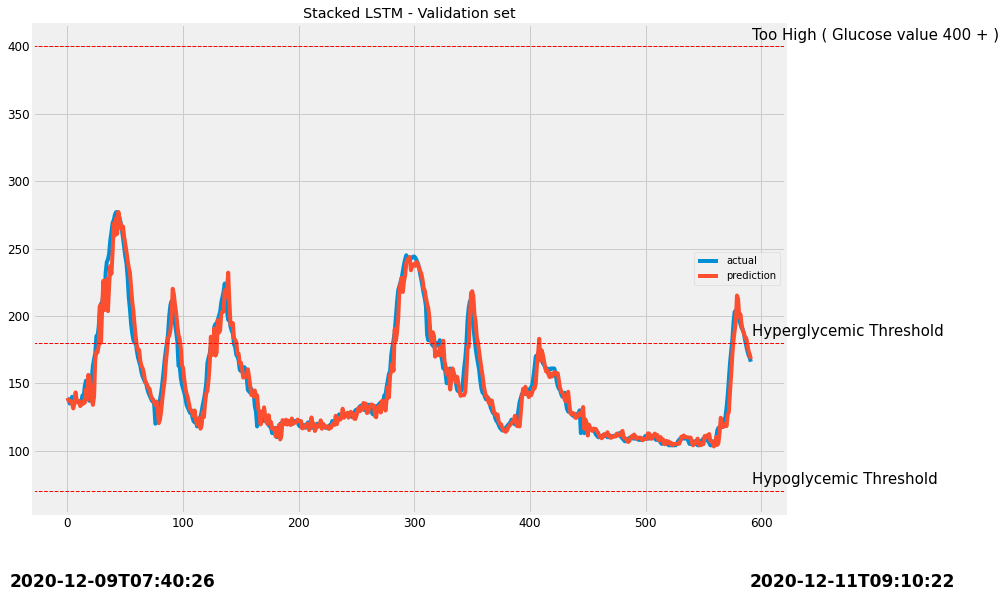

In [181]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

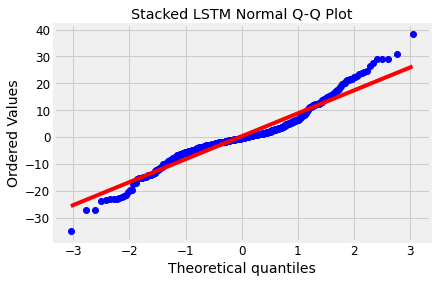

In [182]:
residuals = [y_val_uni[i]-val_slstm_15_predict_result[i] for i in range(len(val_slstm_15_predict_result))]
residuals = y_val_uni - val_slstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [183]:
# 트레이닝셋 RMSE 계산 
train_slstm_15_predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(train_slstm_15_predict_result)):
    if train_slstm_15_predict_result[i] >= 400: 
        train_slstm_15_predict_result[i]=400
    elif train_slstm_15_predict_result[i] <= 60: 
        train_slstm_15_predict_result[i]=60
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_slstm_15_predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,train_slstm_15_predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  11.241786075934394


In [184]:
get_train_slstm_15_predict_result = np.array(train_slstm_15_predict_result)

In [185]:
get_train_slstm_15_predict_result = get_train_slstm_15_predict_result.T

In [186]:
get_train_slstm_15_predict_result.shape

(1, 1391)

#### Train

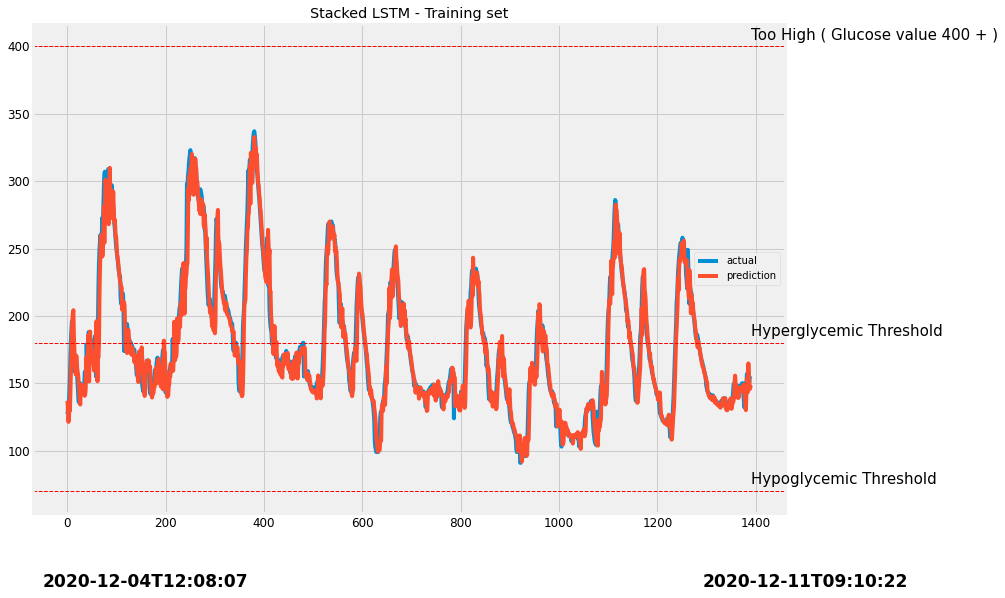

In [187]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(train_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_slstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [188]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [189]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [190]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [191]:
K.clear_session()

In [192]:
val_bilstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [193]:
for i in range(len(val_bilstm_15_predict_result)):
    if val_bilstm_15_predict_result[i] >= 400: 
        val_bilstm_15_predict_result[i]=400
    elif val_bilstm_15_predict_result[i] <= 60: 
        val_bilstm_15_predict_result[i]=60

In [194]:
get_val_bilstm_15_predict_result = np.array(val_bilstm_15_predict_result)

In [195]:
get_val_bilstm_15_predict_result = get_val_bilstm_15_predict_result.T

In [196]:
get_val_bilstm_15_predict_result.shape

(1, 592)

In [197]:
val_bilstm_15_predict_result

array([[140.15694 ],
       [136.89201 ],
       [136.83348 ],
       [136.75987 ],
       [135.90099 ],
       [132.62498 ],
       [135.07878 ],
       [141.83247 ],
       [138.56361 ],
       [136.9775  ],
       [136.9964  ],
       [134.11702 ],
       [134.73555 ],
       [134.8524  ],
       [136.80034 ],
       [136.42598 ],
       [143.8734  ],
       [139.70271 ],
       [155.91689 ],
       [158.69783 ],
       [150.23961 ],
       [138.69241 ],
       [134.56001 ],
       [140.42134 ],
       [164.36101 ],
       [176.93954 ],
       [181.15425 ],
       [181.23889 ],
       [200.92212 ],
       [188.89088 ],
       [197.88484 ],
       [220.59598 ],
       [215.24681 ],
       [208.62148 ],
       [215.20091 ],
       [199.12366 ],
       [244.12863 ],
       [248.53543 ],
       [244.75179 ],
       [243.19972 ],
       [258.1138  ],
       [262.6869  ],
       [269.7817  ],
       [265.70605 ],
       [268.52197 ],
       [267.82855 ],
       [265.9172  ],
       [263.0

In [198]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,val_bilstm_15_predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,val_bilstm_15_predict_result)

Bidirectional LSTM - RMSE :  8.970824989370385


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

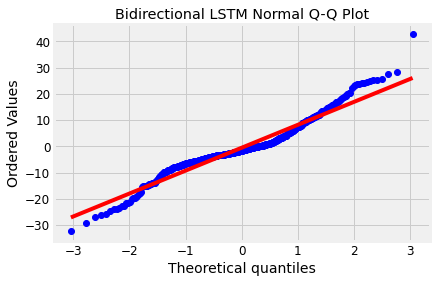

In [199]:
residuals = [y_val_uni[i]-val_bilstm_15_predict_result[i] for i in range(len(val_bilstm_15_predict_result))]
residuals = y_val_uni - val_bilstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

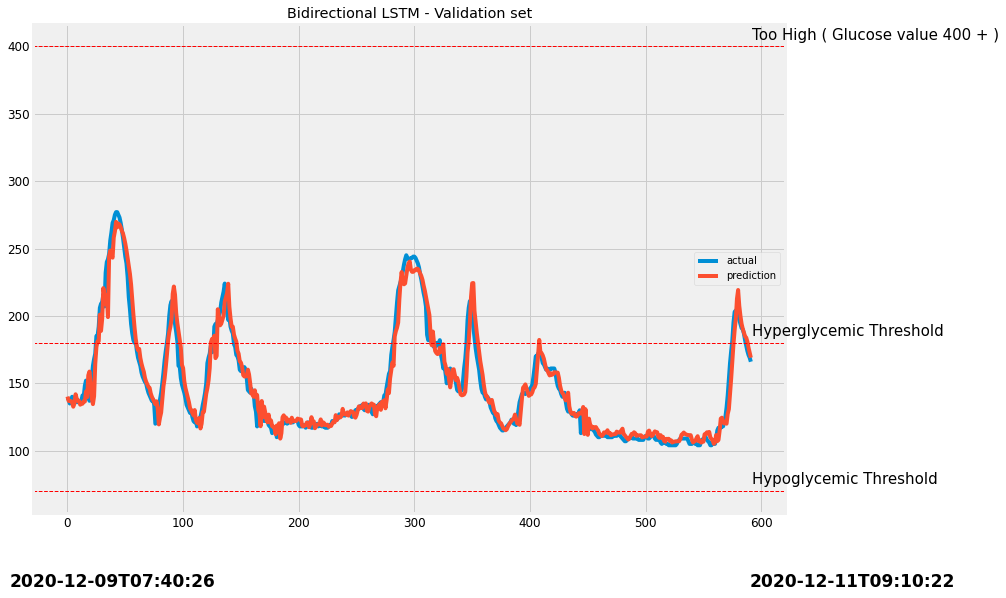

In [200]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [201]:
# 트레이닝셋 RMSE 계산 
train_bilstm_15_predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(train_bilstm_15_predict_result)):
    if train_bilstm_15_predict_result[i] >= 400: 
        train_bilstm_15_predict_result[i]=400
    elif train_bilstm_15_predict_result[i] <= 60: 
        train_bilstm_15_predict_result[i]=60
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,train_bilstm_15_predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,train_bilstm_15_predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  11.67158097381495


In [202]:
get_train_bilstm_15_predict_result = np.array(train_bilstm_15_predict_result)

In [203]:
get_train_bilstm_15_predict_result = get_train_bilstm_15_predict_result.T

In [204]:
get_train_bilstm_15_predict_result.shape

(1, 1391)

#### Train

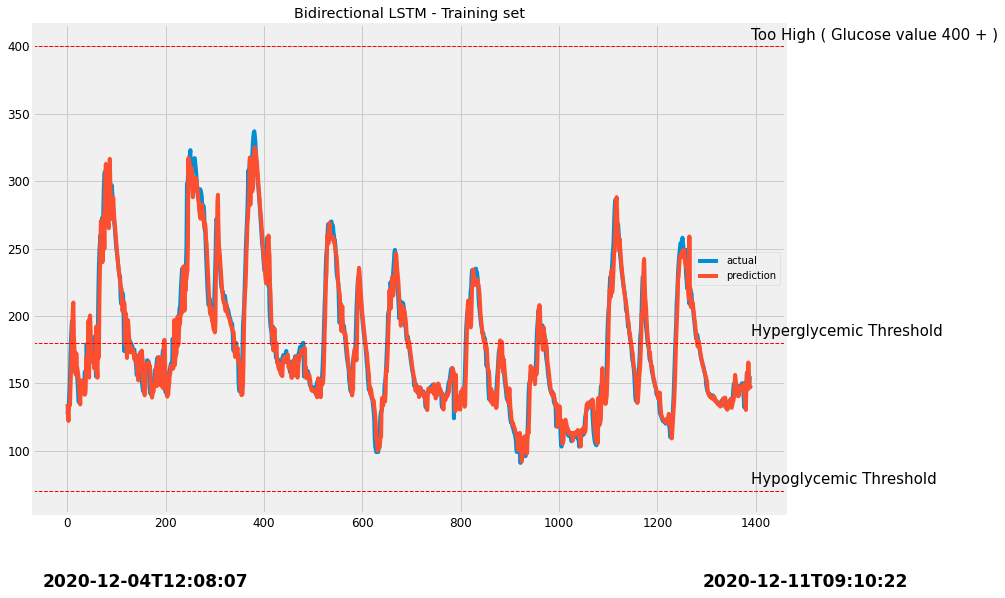

In [205]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(train_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_bilstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [206]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [207]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [208]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [209]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [210]:
K.clear_session()

In [211]:
val_gru_15_predict_result = model.predict(x_val_uni,verbose=0)

In [212]:
for i in range(len(val_gru_15_predict_result)):
    if val_gru_15_predict_result[i] >= 400: 
        val_gru_15_predict_result[i]=400
    if val_gru_15_predict_result[i] <= 60: 
        val_gru_15_predict_result[i]=60

In [213]:
get_val_gru_15_predict_result = np.array(val_gru_15_predict_result)

In [214]:
get_val_gru_15_predict_result = get_val_gru_15_predict_result.T

In [215]:
get_val_gru_15_predict_result.shape

(1, 592)

In [216]:
val_gru_15_predict_result

array([[138.274   ],
       [133.84677 ],
       [136.51797 ],
       [137.1568  ],
       [135.75577 ],
       [132.1939  ],
       [135.84082 ],
       [143.20221 ],
       [138.9713  ],
       [136.56181 ],
       [137.7363  ],
       [134.49055 ],
       [135.03654 ],
       [135.46413 ],
       [137.43932 ],
       [136.81526 ],
       [144.61058 ],
       [140.1198  ],
       [154.67984 ],
       [158.4205  ],
       [149.26337 ],
       [137.7789  ],
       [132.40358 ],
       [142.12862 ],
       [160.34244 ],
       [174.30511 ],
       [174.74236 ],
       [176.74156 ],
       [199.79257 ],
       [186.63966 ],
       [199.00652 ],
       [220.71136 ],
       [214.15894 ],
       [207.44489 ],
       [222.17992 ],
       [203.49373 ],
       [232.72725 ],
       [253.33997 ],
       [241.78864 ],
       [244.3378  ],
       [268.22708 ],
       [262.8262  ],
       [269.3377  ],
       [264.9793  ],
       [272.8066  ],
       [271.1621  ],
       [269.11322 ],
       [266.0

In [217]:
#predict_result

In [218]:
#predict_result

In [219]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,val_gru_15_predict_result))
val_gru_15 = RMSE(y_val_uni_origin,val_gru_15_predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  8.699776409070807


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

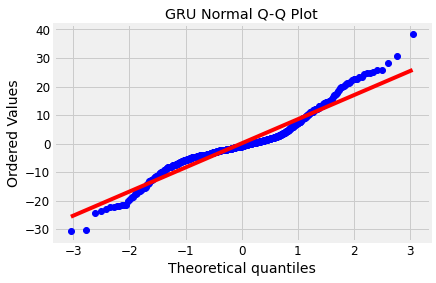

In [220]:
residuals = [y_val_uni[i]-val_gru_15_predict_result[i] for i in range(len(val_gru_15_predict_result))]
residuals = y_val_uni - val_gru_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

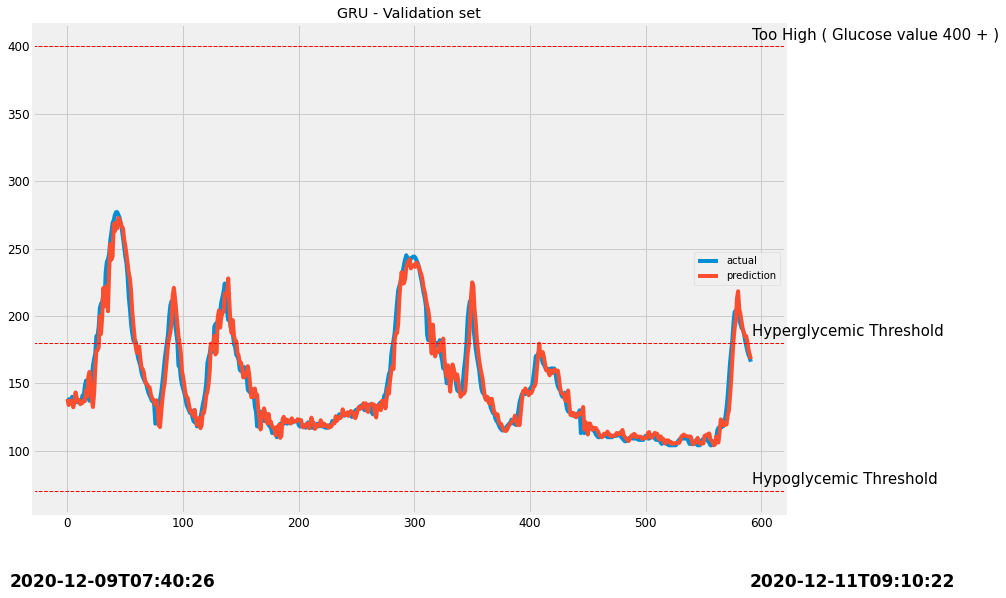

In [221]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [222]:
# 트레이닝셋 RMSE 계산 

train_gru_15_predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(train_gru_15_predict_result)):
    if train_gru_15_predict_result[i] >= 400: 
        train_gru_15_predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_gru_15_predict_result))
train_gru_15 =RMSE(y_train_uni_origin,train_gru_15_predict_result)

 Training set / GRU - RMSE (15min) Training set :  11.484376054194689


In [223]:
get_train_gru_15_predict_result = np.array(train_gru_15_predict_result)

In [224]:
get_train_gru_15_predict_result = get_train_gru_15_predict_result.T

In [225]:
get_train_gru_15_predict_result.shape

(1, 1391)

#### Train

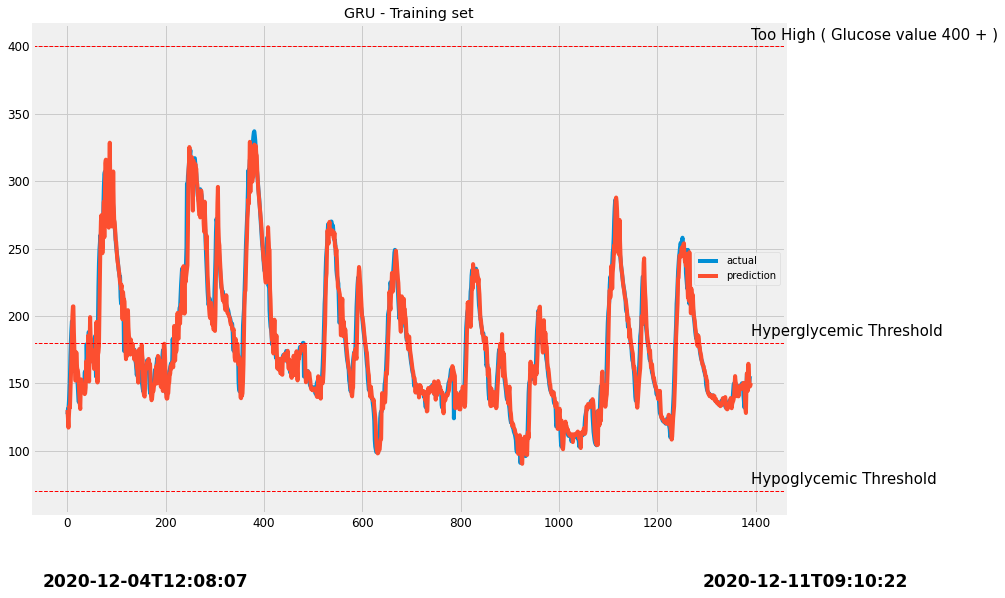

In [226]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(train_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_gru_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [227]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [228]:
#residuals.plot(kind='kde')

In [229]:
#residuals.plot()

In [230]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

### Genetic Algorithm - 15Min

In [231]:
pip install geneticalgorithm2

In [232]:
from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [233]:
val_rnn_15 = round(val_rnn_15,2)
val_lstm_15 = round(val_lstm_15,2)
val_stacklstm_15 = round(val_stacklstm_15,2)
val_bilstm_15 = round(val_bilstm_15,2)
val_gru_15 = round(val_gru_15,2)


In [234]:
train_rnn_15 = round(train_rnn_15,2)
train_lstm_15 = round(train_lstm_15,2)
train_stacklstm_15 = round(train_stacklstm_15,2)
train_bilstm_15 = round(train_bilstm_15,2)
train_gru_15 = round(train_gru_15,2)


In [235]:
#val_rnn_15_predict_result[:5]

In [236]:
#ex = val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2

In [237]:
#ex = val_rnn_15_predict_result * 0.3 + val_lstm_15_predict_result * 0.1 + val_slstm_15_predict_result * 0.14 + val_bilstm_15_predict_result * 0.11 + val_gru_15_predict_result * 0.35

In [238]:
# Baseline
#test_result = RMSE(y_val_uni_origin,ex)
#test_result

In [239]:
#test_result = 200 - RMSE(y_val_uni_origin,ex)
#test_result = 200 - RMSE(val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2,ex)


In [240]:
train_rnn_15_predict_result = np.asarray(train_rnn_15_predict_result)
train_lstm_15_predict_result = np.asarray(train_lstm_15_predict_result)
train_slstm_15_predict_result = np.asarray(train_slstm_15_predict_result)
train_bilstm_15_predict_result = np.asarray(train_bilstm_15_predict_result)
train_gru_15_predict_result = np.asarray(train_gru_15_predict_result)

In [241]:
val_rnn_15_predict_result = np.asarray(val_rnn_15_predict_result)
val_lstm_15_predict_result = np.asarray(val_lstm_15_predict_result)
val_slstm_15_predict_result = np.asarray(val_slstm_15_predict_result)
val_bilstm_15_predict_result = np.asarray(val_bilstm_15_predict_result)
val_gru_15_predict_result = np.asarray(val_gru_15_predict_result)

In [242]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 30 - np.sqrt(mean_squared_error(train_rnn_15_predict_result * X[0] + train_lstm_15_predict_result * X[1] +train_slstm_15_predict_result * X[2] + 
                                train_bilstm_15_predict_result * X[3] + train_gru_15_predict_result * X[4],y_train_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [243]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [244]:
algorithm_param = {'max_num_iteration': 10000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [245]:
model1 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.22647586]

 ** C ** 

18.766475487827286

 ** B ** 

[0.05424643 0.16714382 0.49977505 0.05235394 0.226475

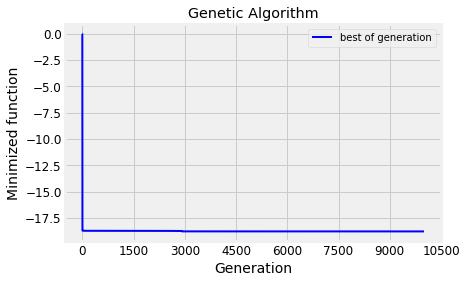

In [246]:
model1.run()

In [247]:
# RMSE 
optimized = val_rnn_15_predict_result * model1.output_dict['variable'][0] + val_lstm_15_predict_result *model1.output_dict['variable'][1] + val_slstm_15_predict_result * model1.output_dict['variable'][2] + val_bilstm_15_predict_result * model1.output_dict['variable'][3] + val_gru_15_predict_result * model1.output_dict['variable'][4]
for i in range(len(optimized)):
    if optimized[i] >= 400: 
        optimized[i]=400
    if optimized[i] <= 60: 
        optimized[i]=60
optimized_rmse_15 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_15

8.712493818176446

In [248]:
optimized

array([[138.93024 ],
       [136.34572 ],
       [137.0988  ],
       [137.05157 ],
       [135.5263  ],
       [131.97432 ],
       [135.36671 ],
       [142.66528 ],
       [137.90248 ],
       [136.37201 ],
       [137.18387 ],
       [133.7771  ],
       [134.75713 ],
       [134.8968  ],
       [137.00774 ],
       [136.14034 ],
       [144.48984 ],
       [138.8396  ],
       [155.11963 ],
       [155.76855 ],
       [148.80237 ],
       [137.91592 ],
       [133.88725 ],
       [140.88748 ],
       [163.77856 ],
       [174.07631 ],
       [175.1214  ],
       [178.37512 ],
       [203.86096 ],
       [184.12476 ],
       [202.60135 ],
       [223.5531  ],
       [209.76779 ],
       [207.21194 ],
       [223.50087 ],
       [202.83542 ],
       [229.98734 ],
       [243.97745 ],
       [237.61919 ],
       [245.93547 ],
       [266.59464 ],
       [261.01416 ],
       [270.92834 ],
       [263.28116 ],
       [274.09937 ],
       [270.73926 ],
       [268.1614  ],
       [264.7

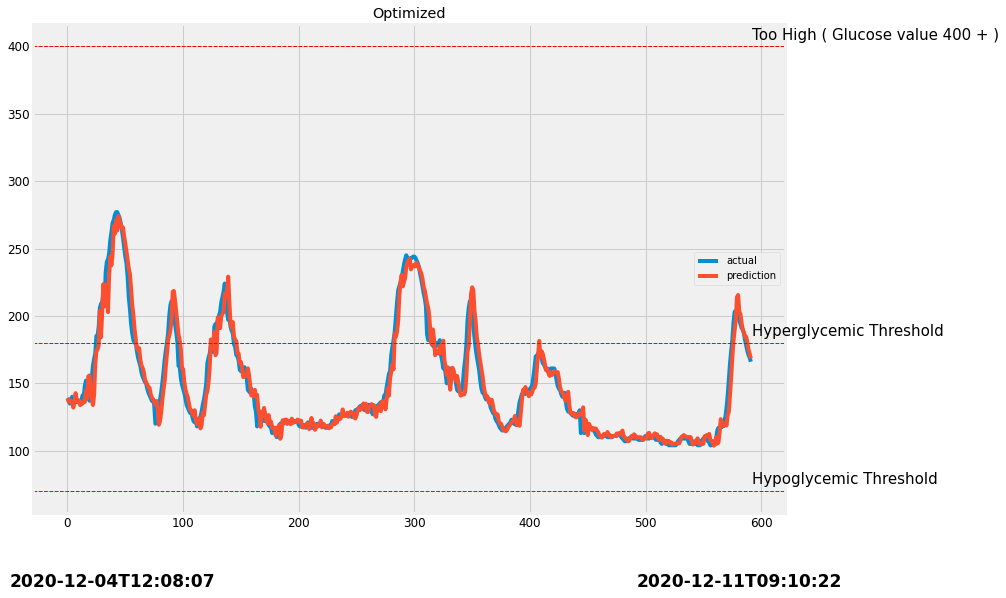

In [249]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

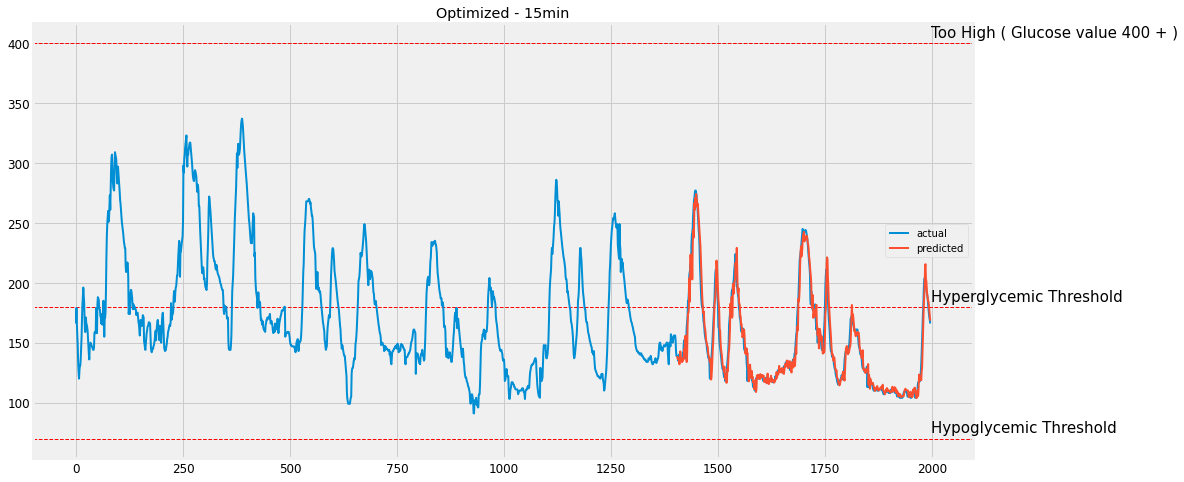

In [250]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 15min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

In [251]:
get_optimized = np.array(optimized)

In [252]:
get_optimized = get_optimized.T

In [253]:
get_optimized.shape

(1, 592)

In [254]:
ar_val_15=np.concatenate((get_y_val_origin_15, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result,get_optimized), axis = 0)


In [255]:
ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [256]:
#ar_val_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result), axis = 0)


In [257]:
#ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [258]:
y1=pd.DataFrame(ar_val_15,index=['15_val_origin','15_val_rnn','15_val_lstm','15_val_slstm','15_val_bilstm','15_val_gru','15_optimized'])
y1

0           1           2           3           4    \
15_val_origin  139.000000  138.000000  135.000000  136.000000  140.000000   
15_val_rnn     135.993332  135.026535  135.709030  136.023453  135.820541   
15_val_lstm    139.709259  138.192474  138.839569  138.186905  136.755386   
15_val_slstm   139.158707  136.947800  136.959793  136.767700  134.941422   
15_val_bilstm  140.156937  136.892014  136.833481  136.759872  135.900986   
15_val_gru     138.274002  133.846771  136.517975  137.156799  135.755768   
15_optimized   138.930237  136.345718  137.098801  137.051575  135.526306   

                      5           6           7           8           9    \
15_val_origin  139.000000  138.000000  138.000000  136.000000  136.000000   
15_val_rnn     131.995499  135.248245  141.320084  139.792328  137.593094   
15_val_lstm    133.348511  135.744568  140.947235  138.078079  137.036346   
15_val_slstm   131.346085  135.069839  143.231186  137.086380  135.869202   
15_val_bilstm  132.624985  135.078781  141.832474  138.563614  136.977493   
15_val_gru     132.193893  135.840820  143.202209  138.971298  136.561813   
15_optimized   131.974319  135.366714  142.665283  137.902481  136.372009   

                      10          11          12          13          14   \
15_val_origin  136.000000  137.000000  137.000000  141.000000  140.000000   
15_val_rnn     137.119141  134.298721  134.496338  134.889236  137.035324   
15_val_lstm    137.394791  134.605743  135.375748  135.315491  136.717377   
15_val_slstm   136.890976  133.085739  134.455490  134.506485  136.929321   
15_val_bilstm  136.996399  134.117020  134.735550  134.852402  136.800339   
15_val_gru     137.736298  134.490555  135.036545  135.464127  137.439316   
15_optimized   137.183868  133.777100  134.757126  134.896805  137.007736   

                      15          16          17          18          19   \
15_val_origin  148.000000  152.000000  150.000000  142.000000  137.000000   
15_val_rnn     136.899796  143.185928  140.809860  152.983170  157.443954   
15_val_lstm    136.334122  142.578568  139.275238  152.824051  156.115845   
15_val_slstm   135.658661  145.281845  137.810867  156.236557  153.963486   
15_val_bilstm  136.425980  143.873398  139.702713  155.916885  158.697830   
15_val_gru     136.815262  144.610580  140.119797  154.679840  158.420502   
15_optimized   136.140335  144.489838  138.839600  155.119629  155.768555   

                      20          21          22          23          24   \
15_val_origin  141.000000  154.000000  163.000000  168.000000  172.000000   
15_val_rnn     152.084839  136.909180  134.216629  141.049683  160.477493   
15_val_lstm    149.949387  139.086411  135.217041  141.039795  158.862717   
15_val_slstm   147.704483  137.615860  134.009933  140.306732  167.278610   
15_val_bilstm  150.239609  138.692413  134.560013  140.421341  164.361008   
15_val_gru     149.263367  137.778900  132.403580  142.128616  160.342438   
15_optimized   148.802368  137.915924  133.887253  140.887482  163.778564   

                      25          26          27          28          29   \
15_val_origin  185.000000  185.000000  192.000000  206.000000  209.000000   
15_val_rnn     174.459198  177.181366  177.962082  195.641037  191.270325   
15_val_lstm    174.184265  179.278671  181.248627  202.317581  189.256470   
15_val_slstm   173.596695  173.048965  177.900955  207.422775  179.995773   
15_val_bilstm  176.939545  181.154251  181.238892  200.922119  188.890884   
15_val_gru     174.305115  174.742355  176.741562  199.792572  186.639664   
15_optimized   174.076309  175.121399  178.375122  203.860962  184.124756   

                      30          31          32          33          34   \
15_val_origin  210.000000  216.000000  207.000000  232.000000  240.000000   
15_val_rnn     196.990036  216.056625  217.494980  211.645584  217.953964   
15_val_lstm    199.655350  223.238785  215.873154  209.627289  218.272797   
15_val_slstm

In [259]:
y1.to_csv("/content/drive/MyDrive/uni_data_result/"+file_name+"_test_15.csv")

In [260]:
y2=pd.DataFrame(ar_train_15,index=['15_train_origin','15_train_rnn','15_train_lstm','15_train_slstm','15_train_bilstm','15_train_gru'])
y2
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

0           1           2           3           4     \
15_train_origin  127.000000  131.000000  131.000000  137.000000  145.000000   
15_train_rnn     122.044052  116.120689  112.360870  126.624084  133.278137   
15_train_lstm    134.400803  131.845291  125.218651  128.267120  132.067383   
15_train_slstm   137.040054  128.764359  121.347481  126.941040  132.250931   
15_train_bilstm  134.588638  128.137344  122.022415  132.408096  133.818558   
15_train_gru     130.154587  123.029900  117.092659  126.538918  133.191391   

                       5           6           7           8           9     \
15_train_origin  155.000000  171.000000  182.000000  190.000000  196.000000   
15_train_rnn     134.191559  141.470825  153.549149  166.689835  186.590012   
15_train_lstm    131.873611  142.270508  154.752594  168.758530  189.234375   
15_train_slstm   129.581177  146.067551  159.822495  172.400467  189.325714   
15_train_bilstm  133.777267  144.874588  156.541550  169.175369  185.789490   
15_train_gru     131.944641  142.825378  155.811554  167.606415  186.909012   

                       10          11          12          13          14    \
15_train_origin  190.000000  183.000000  169.000000  159.000000  159.000000   
15_train_rnn     198.235565  202.934647  204.710068  189.690567  178.155167   
15_train_lstm    199.230042  207.190079  210.455521  188.945114  177.175690   
15_train_slstm   197.746124  202.348831  204.221603  185.695999  174.807816   
15_train_bilstm  197.611130  206.950424  209.907272  184.738647  176.987167   
15_train_gru     200.310944  207.000885  207.092758  188.638458  175.415146   

                       15          16          17          18          19    \
15_train_origin  171.000000  166.000000  165.000000  163.000000  160.000000   
15_train_rnn     158.693542  150.121628  153.383362  171.087448  164.789886   
15_train_lstm    163.806366  158.847488  161.547409  170.410965  163.077789   
15_train_slstm   165.207916  160.030258  156.424454  170.409897  163.959549   
15_train_bilstm  166.877731  158.178284  156.206284  172.123459  161.787979   
15_train_gru     162.524704  151.975052  152.144165  172.936417  163.566452   

                       20          21          22          23          24    \
15_train_origin  154.000000  147.000000  140.000000  136.000000  146.000000   
15_train_rnn     162.604477  160.002197  156.199997  147.216019  140.315125   
15_train_lstm    162.702133  160.087418  156.916092  150.627045  144.357040   
15_train_slstm   160.468887  157.845322  154.993805  148.427841  143.286728   
15_train_bilstm  161.475113  158.581360  155.850845  150.157974  144.121964   
15_train_gru     160.530090  159.794647  156.167618  148.664856  141.422791   

                       25          26          27          28          29    \
15_train_origin  149.000000  150.000000  149.000000  148.000000  147.000000   
15_train_rnn     132.997025  130.360855  147.842560  152.276306  153.102219   
15_train_lstm    138.786896  136.250473  146.082291  149.356293  150.715515   
15_train_slstm   137.958054  134.265701  145.146378  147.966034  148.997726   
15_train_bilstm  138.139755  134.305130  149.997986  151.279648  152.220245   
15_train_gru     134.599106  130.911316  147.620071  152.871948  149.913330   

                       30          31          32          33          34    \
15_train_origin  146.000000  145.000000  144.000000  144.000000  146.000000   
15_train_rnn     148.960419  147.262817  144.907089  143.629669  142.522095   
15_train_lstm    148.233276  146.635406  145.371429  144.391022  143.439987   
15_train_slstm   146.138031  145.949081  143.840286  142.692825  141.644363   
15_train_bilstm  147.968369  145.934387  144.433029  143.371811  142.397446   
15_train_gru     147.510178  147.033127  145.297256  144.034470  142.912506   

                       35          36          37          38          39    \
15_train_origin  158.000000  159.000000  158.000000  158.000000  1

In [261]:
y2.to_csv("/content/drive/MyDrive/uni_data_result/"+file_name+"_train_15.csv")

#### GA_Residual

Text(0.5, 1.0, '15Min GA Normal Q-Q Plot')

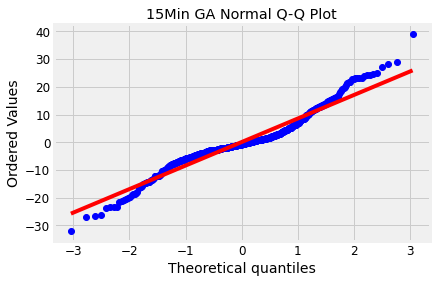

In [262]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("15Min GA Normal Q-Q Plot")

Text(0.5, 1.0, '15Min GA Normal Q-Q Plot')

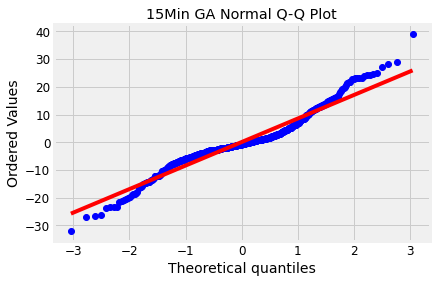

In [263]:
probplot(residuals,dist="norm",plot=plt)
plt.title("15Min GA Normal Q-Q Plot")

In [264]:
residuals=DataFrame(residuals)

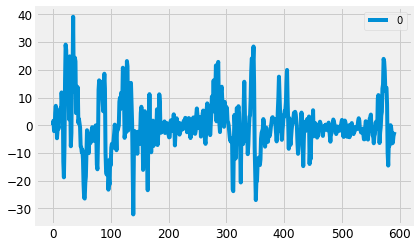

In [265]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbfdf1ac50>]],
      dtype=object)

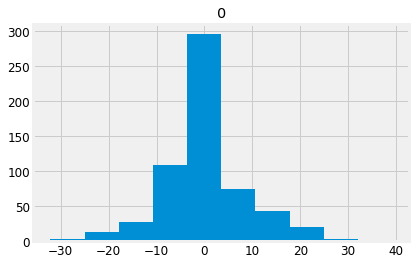

In [266]:

residuals.hist()

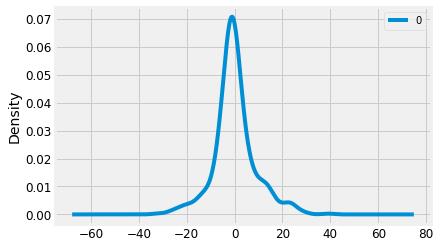

In [267]:
residuals.plot(kind='kde')

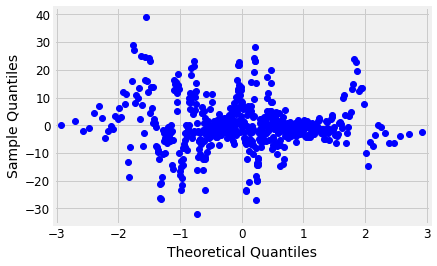

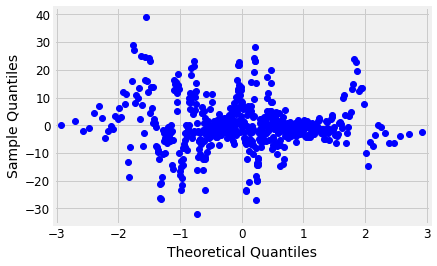

In [268]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## 30분

In [269]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [270]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=5
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [271]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [272]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [273]:
y_val_uni.shape


(589,)

In [274]:

x_val_uni.shape

(589, 6, 1)

In [275]:
x_train_uni[0]

array([[166],
       [179],
       [165],
       [157],
       [147],
       [133]])

In [276]:
df['Glucose'].head(15)

0     166.0
1     179.0
2     165.0
3     157.0
4     147.0
5     133.0
6     125.0
7     120.0
8     127.0
9     131.0
10    131.0
11    137.0
12    145.0
13    155.0
14    171.0
Name: Glucose, dtype: float64

In [277]:
y_train_uni[0]

137

### RNN - 30분

In [278]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [279]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [280]:
model.compile(optimizer='adam',loss='mse')

In [281]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [282]:
val_rnn_30_predict_result = model.predict(x_val_uni,verbose=0)

In [283]:
K.clear_session()

In [284]:
predict_result = model.predict(x_val_uni,verbose=0)

In [285]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
# GA에 사용 
val_rnn_30_predict_result = predict_result

In [286]:
get_x_train_origin_30 = np.array(y_train_uni_origin)

In [287]:
get_x_train_origin_30 = get_x_train_origin_30.reshape(1,len(y_train_uni_origin))

In [288]:
get_x_train_origin_30.shape

(1, 1391)

In [289]:
get_y_val_origin_30 = np.array(y_val_uni_origin)

In [290]:
get_y_val_origin_30 = get_y_val_origin_30.reshape(1,len(get_y_val_origin_30))

In [291]:
get_y_val_origin_30.shape

(1, 589)

In [292]:
#get_y_val_origin

In [293]:
get_val_rnn_30_predict_result = np.array(val_rnn_30_predict_result)

In [294]:
get_val_rnn_30_predict_result = get_val_rnn_30_predict_result.T

In [295]:
get_val_rnn_30_predict_result.shape

(1, 589)

In [296]:
#ar_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result), axis = 0)


In [297]:
#y=pd.DataFrame(ar,index=['15_val_origin','15_rnn'])
#y
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

In [298]:
#get_val_rnn_15_pedict_result =get_val_rnn_15_pedict_result.reshape(1,len(get_val_rnn_15_pedict_result))

In [299]:
get_val_rnn_30_predict_result.shape

(1, 589)

In [300]:
val_rnn_30_predict_result

array([[137.51839 ],
       [134.42404 ],
       [137.33925 ],
       [137.09769 ],
       [137.4672  ],
       [135.03758 ],
       [138.50908 ],
       [145.45692 ],
       [144.69147 ],
       [142.00548 ],
       [141.87555 ],
       [138.15259 ],
       [138.2109  ],
       [138.38269 ],
       [141.05234 ],
       [141.08095 ],
       [148.36482 ],
       [146.18663 ],
       [159.34996 ],
       [164.6662  ],
       [159.16277 ],
       [142.18675 ],
       [135.33643 ],
       [142.81563 ],
       [164.51057 ],
       [181.90865 ],
       [185.57623 ],
       [186.87817 ],
       [205.17126 ],
       [198.86436 ],
       [203.86137 ],
       [222.38377 ],
       [224.1145  ],
       [216.5924  ],
       [222.51338 ],
       [202.82115 ],
       [243.98076 ],
       [252.91383 ],
       [253.19301 ],
       [249.18436 ],
       [264.18164 ],
       [265.20703 ],
       [271.7264  ],
       [270.0437  ],
       [273.61407 ],
       [271.3342  ],
       [268.6838  ],
       [262.9

In [301]:
y_val_uni_origin

array([136, 140, 139, 138, 138, 136, 136, 136, 137, 137, 141, 140, 148,
       152, 150, 142, 137, 141, 154, 163, 168, 172, 185, 185, 192, 206,
       209, 210, 216, 207, 232, 240, 242, 246, 256, 262, 269, 271, 275,
       277, 277, 275, 273, 269, 264, 258, 251, 244, 239, 229, 214, 205,
       194, 187, 182, 180, 181, 174, 169, 166, 163, 158, 155, 153, 151,
       150, 146, 143, 141, 139, 137, 138, 134, 120, 121, 126, 132, 138,
       143, 150, 158, 167, 174, 180, 187, 200, 208, 211, 208, 202, 194,
       188, 181, 163, 163, 154, 149, 146, 143, 139, 134, 132, 130, 128,
       130, 125, 122, 121, 123, 118, 119, 124, 125, 129, 134, 138, 143,
       150, 165, 169, 172, 178, 173, 174, 192, 194, 194, 197, 200, 203,
       210, 214, 218, 224, 215, 203, 197, 199, 192, 189, 187, 179, 177,
       171, 170, 167, 160, 159, 159, 159, 162, 160, 154, 145, 144, 143,
       146, 143, 143, 133, 129, 118, 127, 126, 129, 128, 124, 122, 125,
       122, 122, 119, 118, 117, 113, 116, 115, 117, 110, 111, 11

In [302]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  16.454592819800865


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

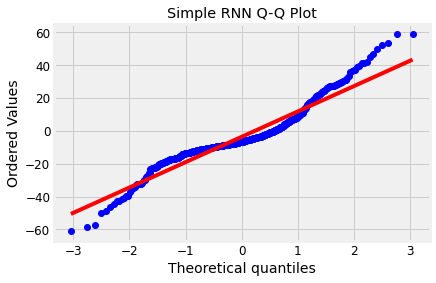

In [303]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

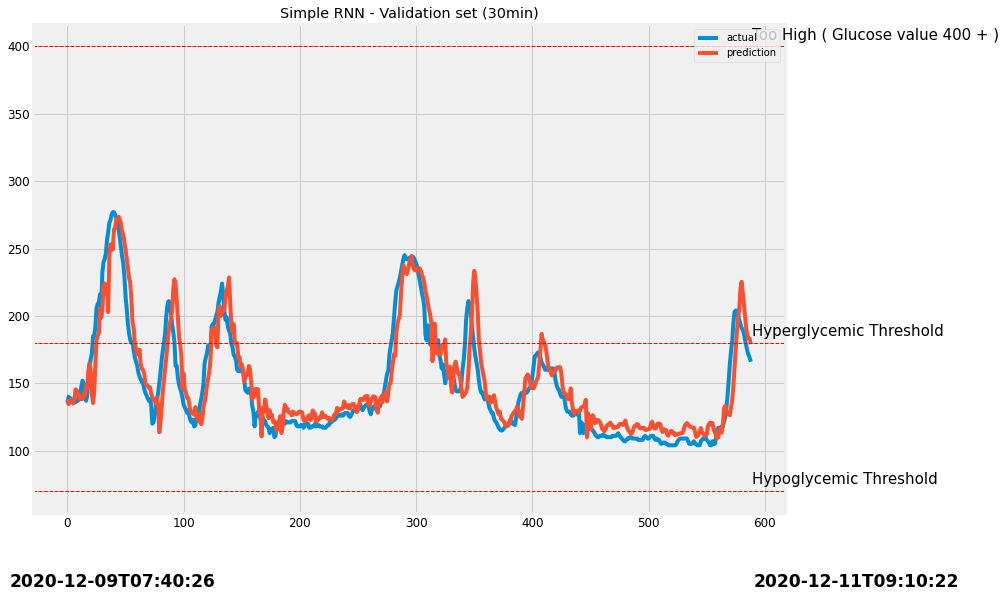

In [304]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

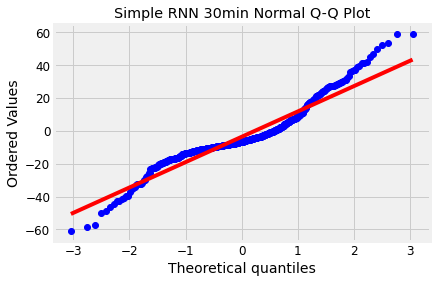

In [305]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [306]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400     
    elif predict_result[i] <= 60: 
        predict_result[i]=60           
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30_predict_result=predict_result
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  19.40851709596357


In [307]:
get_train_rnn_30_predict_result = np.array(train_rnn_30_predict_result)

In [308]:
get_train_rnn_30_predict_result = get_train_rnn_30_predict_result.T

In [309]:
get_train_rnn_30_predict_result.shape

(1, 1391)

#### Train

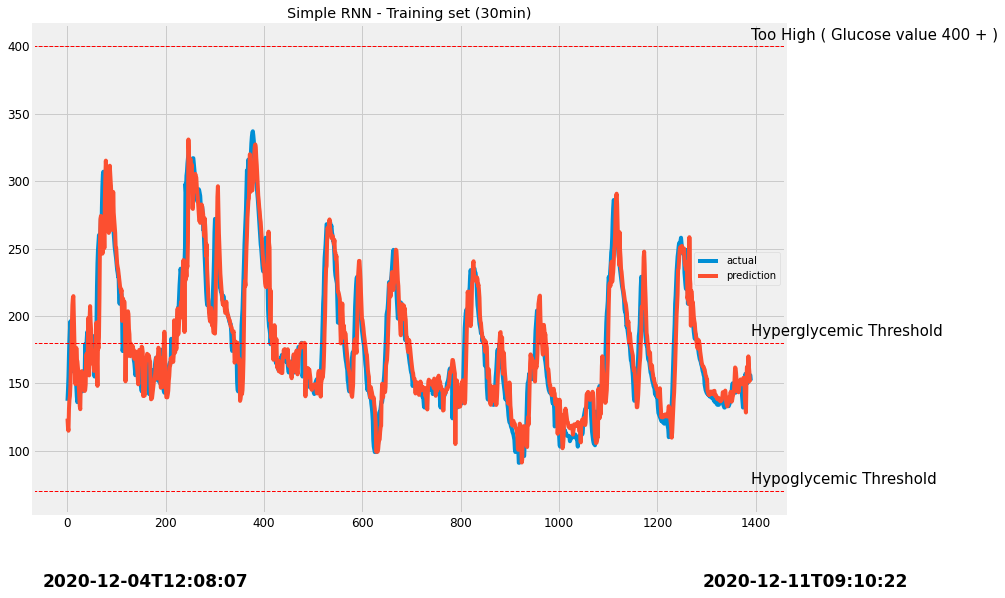

In [310]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [311]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [312]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [313]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
val_lstm_30_predict_result = model.predict(x_val_uni,verbose=0)
K.clear_session()

In [314]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result
val_lstm_30_predict_result=predict_result
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  16.48789585678335


In [315]:
get_val_lstm_30_predict_result = np.array(val_lstm_30_predict_result)

In [316]:
get_val_lstm_30_predict_result = get_val_lstm_30_predict_result.T

In [317]:
get_val_lstm_30_predict_result.shape

(1, 589)

In [318]:
predict_result

array([[142.98598 ],
       [139.81245 ],
       [139.45189 ],
       [138.5726  ],
       [138.01521 ],
       [135.69792 ],
       [138.23909 ],
       [145.3969  ],
       [142.1255  ],
       [140.80026 ],
       [141.02406 ],
       [137.54732 ],
       [137.81354 ],
       [138.10251 ],
       [140.1063  ],
       [140.01521 ],
       [148.61568 ],
       [144.1465  ],
       [163.54965 ],
       [167.98703 ],
       [156.83723 ],
       [142.17752 ],
       [138.16663 ],
       [142.85614 ],
       [169.7483  ],
       [187.29123 ],
       [193.97998 ],
       [196.52356 ],
       [213.72775 ],
       [201.23836 ],
       [209.55313 ],
       [231.09943 ],
       [226.18837 ],
       [218.315   ],
       [225.03262 ],
       [198.62738 ],
       [250.58286 ],
       [254.89197 ],
       [250.94746 ],
       [252.62419 ],
       [265.14758 ],
       [265.3045  ],
       [272.19843 ],
       [271.2016  ],
       [273.7337  ],
       [272.33963 ],
       [267.5501  ],
       [260.1

#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

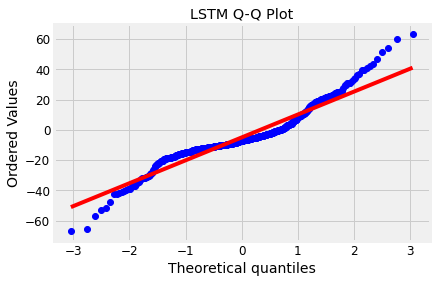

In [319]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

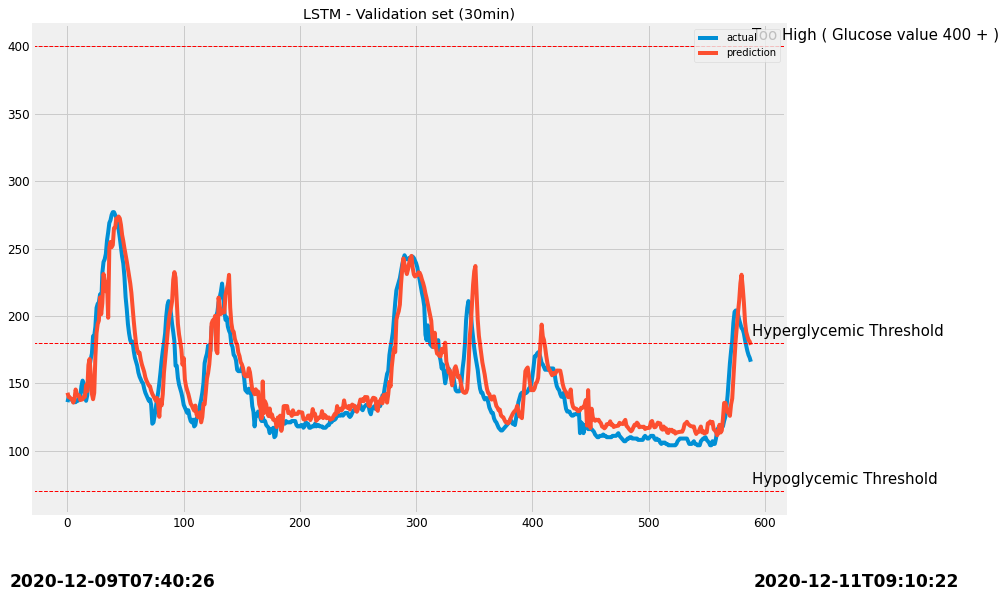

In [320]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [321]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60

train_lstm_30_predict_result = predict_result
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  19.182173776234773


In [322]:
get_train_lstm_30_predict_result = np.array(train_lstm_30_predict_result)

In [323]:
get_train_lstm_30_predict_result = get_train_lstm_30_predict_result.T

In [324]:
get_train_lstm_30_predict_result.shape

(1, 1391)

#### Train

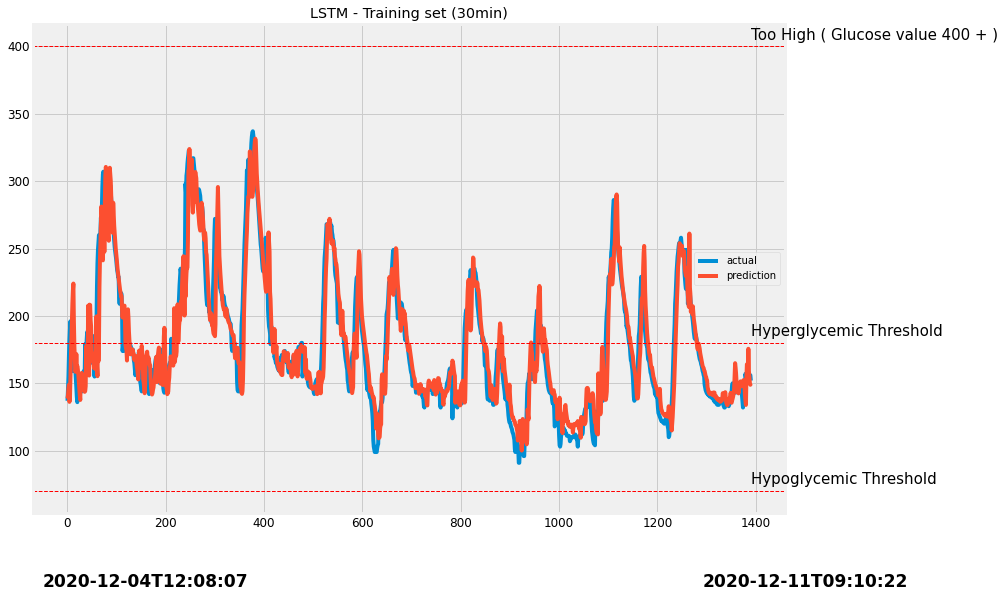

In [325]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [326]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [327]:
model = Sequential()
#model.Flatten()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [328]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [329]:
K.clear_session()

In [330]:
val_slstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [331]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

val_slstm_30_predict_result=predict_result

 Stacked LSTM - RMSE(15min) :  15.819766940309778


In [332]:
get_val_slstm_30_predict_result = np.array(val_slstm_30_predict_result)

In [333]:
get_val_slstm_30_predict_result = get_val_slstm_30_predict_result.T

In [334]:
get_val_slstm_30_predict_result.shape

(1, 589)

In [335]:
predict_result

array([[139.61385 ],
       [136.50517 ],
       [139.70802 ],
       [142.04341 ],
       [135.97394 ],
       [132.47371 ],
       [135.39674 ],
       [150.56058 ],
       [141.17604 ],
       [137.11688 ],
       [138.10919 ],
       [135.36009 ],
       [134.8666  ],
       [136.20386 ],
       [138.48714 ],
       [137.50056 ],
       [148.46663 ],
       [142.25964 ],
       [163.0622  ],
       [167.98277 ],
       [152.4906  ],
       [144.06471 ],
       [139.67638 ],
       [144.51852 ],
       [169.67334 ],
       [175.04689 ],
       [187.46112 ],
       [189.03606 ],
       [208.16718 ],
       [202.97401 ],
       [201.23189 ],
       [224.25792 ],
       [226.56026 ],
       [205.63779 ],
       [220.63219 ],
       [199.84781 ],
       [244.91324 ],
       [242.85033 ],
       [242.10226 ],
       [236.88574 ],
       [267.4749  ],
       [267.546   ],
       [271.27744 ],
       [265.14783 ],
       [265.73303 ],
       [266.6399  ],
       [261.74634 ],
       [255.9

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

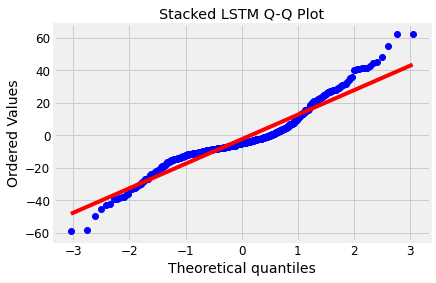

In [336]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

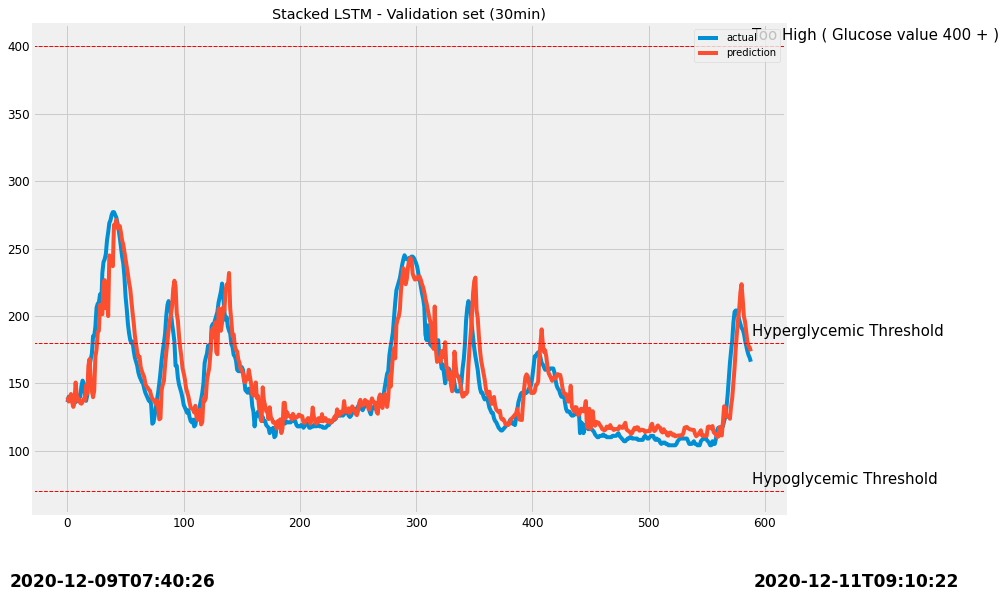

In [337]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [338]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)
train_slstm_30_predict_result=predict_result

 Training set / STACKED LSTM - RMSE (15min) Training set :  19.012401806350525


In [339]:
get_train_slstm_30_predict_result = np.array(train_slstm_30_predict_result)

In [340]:
get_train_slstm_30_predict_result = get_train_slstm_30_predict_result.T

In [341]:
get_train_slstm_30_predict_result.shape

(1, 1391)

#### Train

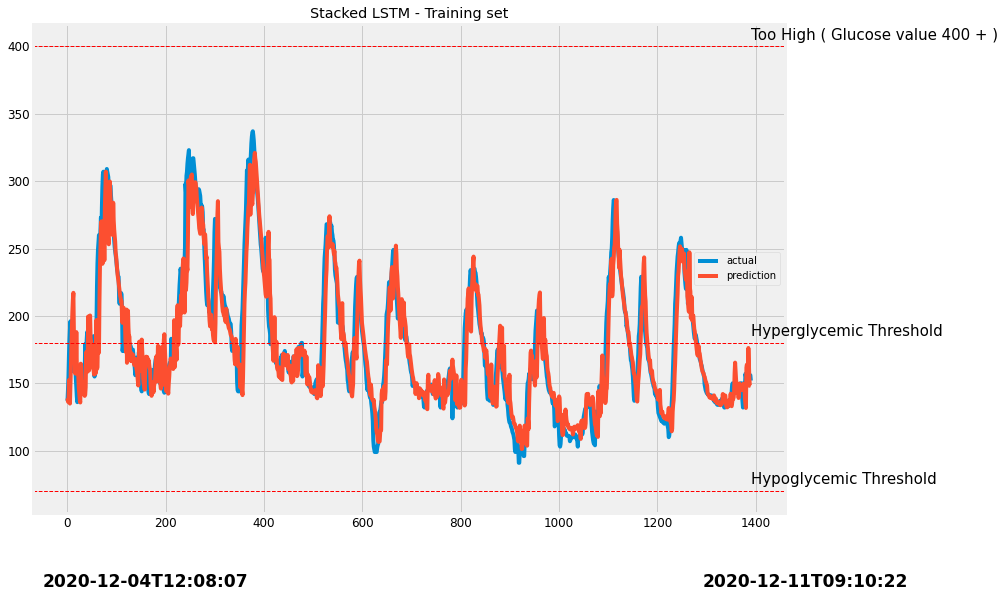

In [342]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [343]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [344]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [345]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [346]:
val_bilstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [347]:
K.clear_session()

In [348]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)
val_bilstm_30_predict_result=predict_result

Bidirectional LSTM - RMSE :  16.577921248475175


In [349]:
get_val_bilstm_30_predict_result = np.array(val_bilstm_30_predict_result)

In [350]:
get_val_bilstm_30_predict_result = get_val_bilstm_30_predict_result.T

In [351]:
get_val_bilstm_30_predict_result.shape

(1, 589)

In [352]:
predict_result

array([[140.40767 ],
       [138.67378 ],
       [139.38849 ],
       [138.57803 ],
       [137.11752 ],
       [134.04414 ],
       [137.45242 ],
       [144.9969  ],
       [140.8804  ],
       [139.65549 ],
       [139.84131 ],
       [135.77762 ],
       [136.78204 ],
       [136.9539  ],
       [139.37054 ],
       [139.0361  ],
       [147.8587  ],
       [142.57523 ],
       [160.99783 ],
       [163.67238 ],
       [153.73032 ],
       [139.82648 ],
       [135.52336 ],
       [144.40396 ],
       [168.16708 ],
       [182.01682 ],
       [188.01886 ],
       [189.62492 ],
       [207.00183 ],
       [194.58528 ],
       [203.29793 ],
       [226.51645 ],
       [219.8569  ],
       [211.2948  ],
       [218.85583 ],
       [196.9429  ],
       [247.79391 ],
       [249.20798 ],
       [245.81235 ],
       [246.65425 ],
       [260.6065  ],
       [262.324   ],
       [269.58688 ],
       [267.47894 ],
       [270.00766 ],
       [267.68414 ],
       [262.98752 ],
       [257.2

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

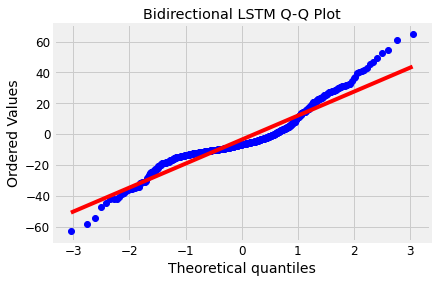

In [353]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

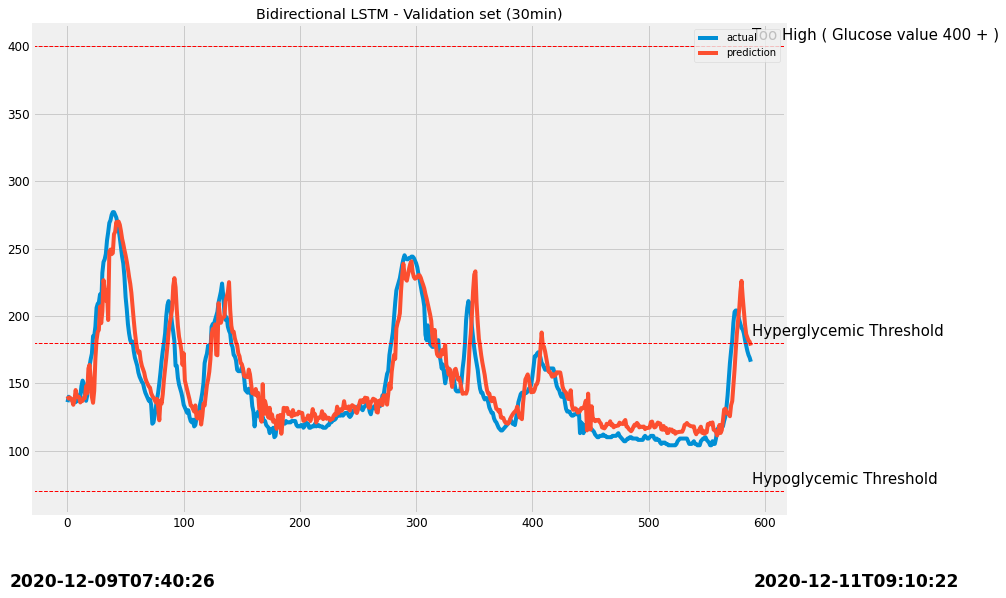

In [354]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [355]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)
train_bilstm_30_predict_result=predict_result

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  19.34022781703505


In [356]:
get_train_bilstm_30_predict_result = np.array(train_bilstm_30_predict_result)

In [357]:
get_train_bilstm_30_predict_result = get_train_bilstm_30_predict_result.T

In [358]:
get_train_bilstm_30_predict_result.shape

(1, 1391)

#### Train

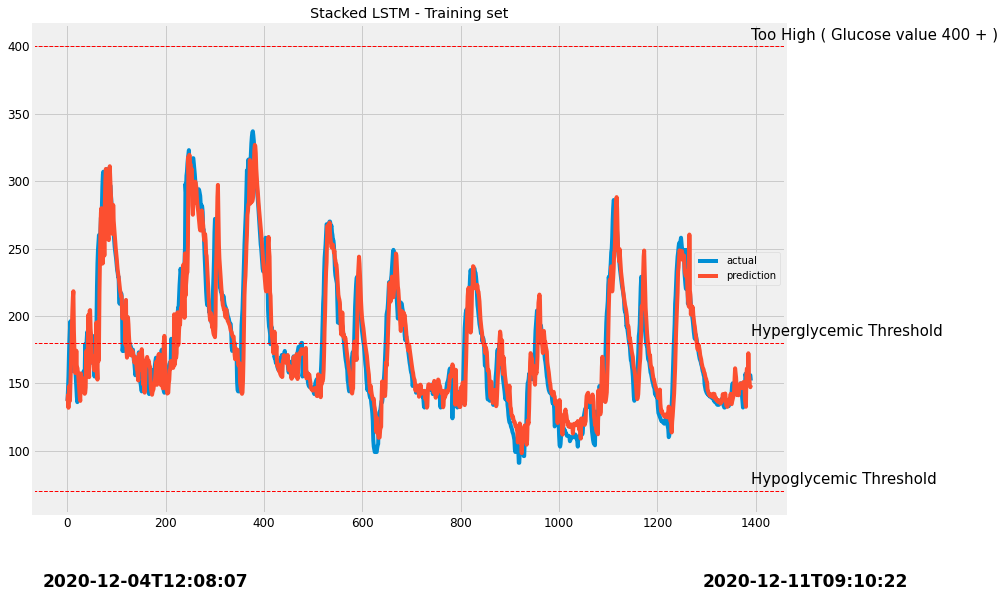

In [359]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [360]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [361]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
#model.add(GRU(50,activation=leaky_relu,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [362]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_gru_30_predict_result = model.predict(x_val_uni,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [363]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63
val_gru_30_predict_result=predict_result

GRU - RMSE 15min :  16.027551632849637


In [364]:
get_val_gru_30_predict_result = np.array(val_gru_30_predict_result)

In [365]:
get_val_gru_30_predict_result = get_val_gru_30_predict_result.T

In [366]:
get_val_gru_30_predict_result.shape

(1, 589)

In [367]:
predict_result

array([[141.57008 ],
       [137.56926 ],
       [137.77466 ],
       [137.98026 ],
       [136.74124 ],
       [134.79372 ],
       [137.79765 ],
       [147.50732 ],
       [141.35406 ],
       [139.6714  ],
       [141.19118 ],
       [137.54044 ],
       [137.15314 ],
       [137.89111 ],
       [140.01906 ],
       [139.47989 ],
       [149.39227 ],
       [143.46474 ],
       [164.54338 ],
       [164.48294 ],
       [154.40485 ],
       [141.4544  ],
       [136.82202 ],
       [143.3743  ],
       [173.3501  ],
       [177.49811 ],
       [179.92542 ],
       [187.67242 ],
       [213.10786 ],
       [191.79768 ],
       [211.07141 ],
       [231.06363 ],
       [214.78201 ],
       [210.25883 ],
       [230.73082 ],
       [205.69173 ],
       [245.24535 ],
       [242.7439  ],
       [243.1154  ],
       [245.84213 ],
       [267.88904 ],
       [259.30923 ],
       [266.13248 ],
       [266.21017 ],
       [270.26242 ],
       [267.95438 ],
       [265.96848 ],
       [261.2

#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

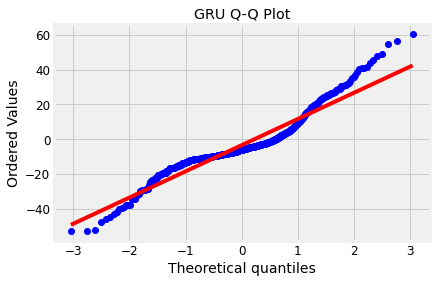

In [368]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

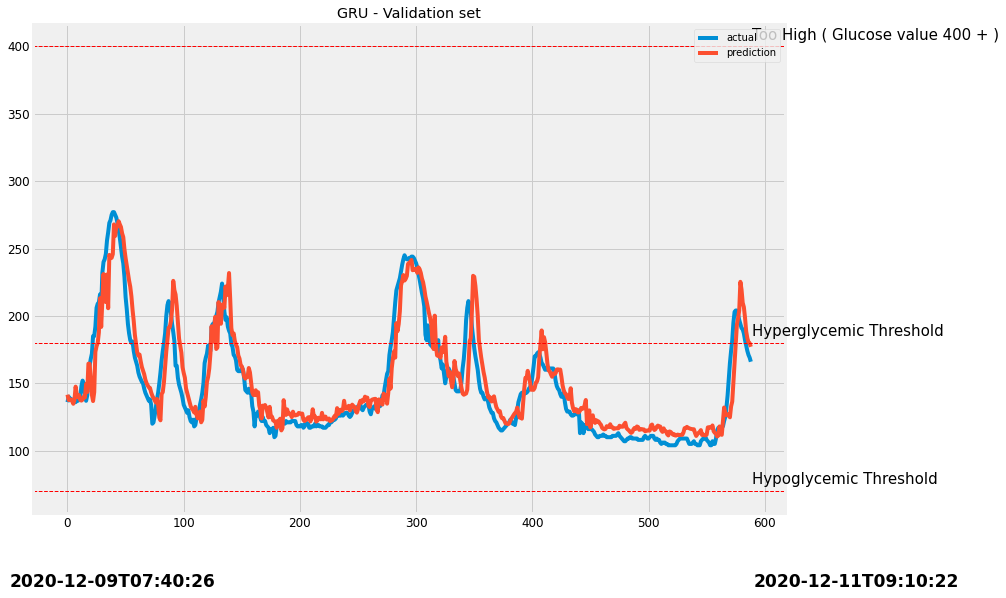

In [369]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [370]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    elif predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)
train_gru_30_predict_result=predict_result

 Training set / GRU - RMSE (15min) Training set :  18.78885273521169


In [371]:
get_train_gru_30_predict_result = np.array(train_gru_30_predict_result)

In [372]:
get_train_gru_30_predict_result = get_train_gru_30_predict_result.T

In [373]:
get_train_gru_30_predict_result.shape

(1, 1391)

#### Train

### GA

In [374]:
#ex = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 + val_gru_30_predict_result * 0.2

In [375]:
#ex2 = val_rnn_30_predict_result * 0.43578443     + val_lstm_30_predict_result *  0.07653674+ val_slstm_30_predict_result *  0.07391771 + val_bilstm_30_predict_result * 0.05667096+ val_gru_30_predict_result *0.34709233

In [376]:
#test_result =  RMSE(y_val_uni_origin,ex2)
#test_result

In [377]:
#test_result =  mean_squared_error(y_val_uni_origin,ex)
#test_result

In [378]:
#test_result * 2 - (1000 + test_result)

In [379]:
#result = (test_result*2) - (1000 + mean_squared_error(y_val_uni_origin,abc))

In [380]:
#mean_squared_error

In [381]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [382]:
train_rnn_30_predict_result = np.asarray(train_rnn_30_predict_result)
train_lstm_30_predict_result = np.asarray(train_lstm_30_predict_result)
train_slstm_30_predict_result = np.asarray(train_slstm_30_predict_result)
train_bilstm_30_predict_result = np.asarray(train_bilstm_30_predict_result)
train_gru_30_predict_result = np.asarray(train_gru_30_predict_result)

In [383]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [384]:
#def evaluate2(X):
#  pen = 0 
  #coef = [0,0,0,0,0]
#  result =0
  #result2 = 0
  #print(X)
#  if sum(X) > 0.99 and sum(X) < 1:
#    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
 #   abc = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
  #  result = (test_result*2) - ((test_result/2) + mean_squared_error(y_val_uni_origin,abc))
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
   # print("\n ** B ** \n")
    #print(X)
    #print()
    #print("\n ** C ** \n")
    #print(result)
  #return np.sum(X) + pen
    #count += 1 
  #return -result
    
    

In [385]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 50 - np.sqrt(mean_squared_error(train_rnn_30_predict_result * X[0] + train_lstm_30_predict_result * X[1] +train_slstm_30_predict_result * X[2] + 
                                train_bilstm_30_predict_result * X[3] + train_gru_30_predict_result * X[4],y_train_uni_origin))
   
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [386]:
#abc.shape

In [387]:
#y_val_uni_origin.shape

In [388]:
#val_rnn_30_predict_result.shape

In [389]:
#abc = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 +val_gru_30_predict_result * 0.2
              

In [390]:
#get = mean_squared_error(y_val_uni_origin,abc)

In [391]:
#test_result*2 - mean_squared_error(y_val_uni_origin,abc)

In [392]:
#varbound = np.array([[500,5000]]*5)

In [393]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [394]:
algorithm_param = {'max_num_iteration': 10000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [395]:
#model = ga(function = evaluate, dimension = 5, variable_type='int',variable_boundaries=varbound,algorithm_parameters = algorithm_param)

In [396]:
model2 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.05293134 0.09833125 0.30942356 0.0522777  0.4868528 ]

 ** C ** 

31.236025701351554

 ** B ** 

[0.05293134 0.09833125 0.30960689 0.0522777  0.4868528 ]

 ** C ** 

31.237868598683676

 ** B ** 

[0.05293134 0.09833125 0.30942356 0.0522777  0.4868528 ]

 ** C ** 

31.236025701351554

 ** B ** 

[0.05293134 0.09833125 0.30960689 0.0522777  0.4868528 ]

 ** C ** 

31.237868598683676

 ** B ** 

[0.05293134 0.09833125 0.30943859 0.0522777  0.4868528 ]

 ** C ** 

31.236179466628602

 ** B ** 

[0.05293134 0.09833125 0.30942356 0.0522777  0.4868528 ]

 ** C ** 

31.236025701351554

 ** B ** 

[0.05293134 0.09833125 0.30942356 0.0522777  0.4868528 ]

 ** C ** 

31.236025701351554

 ** B ** 

[0.05293134 0.09833125 0.30942356 0.0522777  0.4868528 ]

 ** C ** 

31.236025701351554

 ** B ** 

[0.05293134 0.09833125 0.30942356 0.0522777  0.4868528 ]

 ** C ** 

31.236025701351554

 ** B ** 

[0.05293134 0.09833125 0.30960689 0.0522777  0.486852

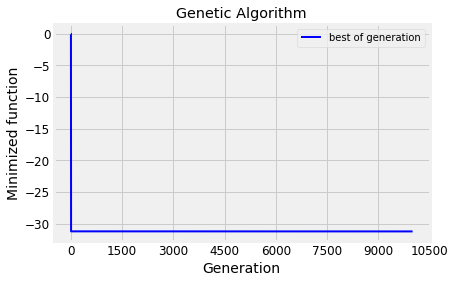

In [397]:
model2.run()

In [398]:
# RMSE 
optimized = val_rnn_30_predict_result * model2.output_dict['variable'][0] + val_lstm_30_predict_result *model2.output_dict['variable'][1] + val_slstm_30_predict_result * model2.output_dict['variable'][2] + val_bilstm_30_predict_result * model2.output_dict['variable'][3] + val_gru_30_predict_result * model2.output_dict['variable'][4]
for i in range(len(optimized)):
    if optimized[i] >= 400: 
        optimized[i]=400
    if optimized[i] <= 60: 
        optimized[i]=60
optimized_rmse_30 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_30

15.957753122770884

In [399]:
optimized

array([[140.8284  ],
       [137.35164 ],
       [138.59949 ],
       [139.281   ],
       [136.68704 ],
       [134.13806 ],
       [137.11732 ],
       [148.00534 ],
       [141.52669 ],
       [139.11423 ],
       [140.18619 ],
       [136.8063  ],
       [136.54674 ],
       [137.36655 ],
       [139.57413 ],
       [138.98126 ],
       [148.89476 ],
       [143.25624 ],
       [163.52682 ],
       [165.87839 ],
       [154.26794 ],
       [142.28732 ],
       [137.69144 ],
       [143.70187 ],
       [171.11873 ],
       [178.17184 ],
       [184.36273 ],
       [189.02498 ],
       [210.89984 ],
       [196.70602 ],
       [207.0877  ],
       [228.26288 ],
       [220.30951 ],
       [210.0097  ],
       [225.98814 ],
       [202.57845 ],
       [245.73364 ],
       [244.84761 ],
       [244.24628 ],
       [243.95541 ],
       [266.9143  ],
       [262.9187  ],
       [268.79852 ],
       [266.6413  ],
       [269.3655  ],
       [268.14337 ],
       [264.8047  ],
       [259.3

In [400]:
get_optimized = np.array(optimized)

In [401]:
get_optimized = get_optimized.T

In [402]:
get_optimized.shape

(1, 589)

In [403]:
ar_val_30=np.concatenate((get_y_val_origin_30, get_val_rnn_30_predict_result,get_val_lstm_30_predict_result,get_val_slstm_30_predict_result,get_val_bilstm_30_predict_result,get_val_gru_30_predict_result,get_optimized), axis = 0)


In [404]:
ar_train_30 = np.concatenate((get_x_train_origin_30, get_train_rnn_30_predict_result ,get_train_lstm_30_predict_result ,get_train_slstm_30_predict_result,get_train_bilstm_30_predict_result,get_train_gru_30_predict_result),axis=0)

In [405]:
#ar_val_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result), axis = 0)


In [406]:
#ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [407]:
y1=pd.DataFrame(ar_val_30,index=['30_val_origin','30_val_rnn','30_val_lstm','30_val_slstm','30_val_bilstm','30_val_gru','30_optimized'])
y1

0           1           2           3           4    \
30_val_origin  136.000000  140.000000  139.000000  138.000000  138.000000   
30_val_rnn     137.518387  134.424042  137.339249  137.097687  137.467194   
30_val_lstm    142.985977  139.812454  139.451889  138.572601  138.015213   
30_val_slstm   139.613846  136.505173  139.708023  142.043411  135.973938   
30_val_bilstm  140.407669  138.673782  139.388489  138.578033  137.117523   
30_val_gru     141.570084  137.569260  137.774658  137.980255  136.741241   
30_optimized   140.828400  137.351639  138.599487  139.281006  136.687042   

                      5           6           7           8           9    \
30_val_origin  136.000000  136.000000  136.000000  137.000000  137.000000   
30_val_rnn     135.037582  138.509079  145.456924  144.691467  142.005478   
30_val_lstm    135.697922  138.239090  145.396896  142.125504  140.800262   
30_val_slstm   132.473709  135.396744  150.560577  141.176041  137.116882   
30_val_bilstm  134.044144  137.452423  144.996902  140.880402  139.655487   
30_val_gru     134.793716  137.797653  147.507324  141.354065  139.671402   
30_optimized   134.138062  137.117325  148.005341  141.526688  139.114227   

                      10          11          12          13          14   \
30_val_origin  141.000000  140.000000  148.000000  152.000000  150.000000   
30_val_rnn     141.875549  138.152588  138.210907  138.382690  141.052338   
30_val_lstm    141.024063  137.547318  137.813538  138.102509  140.106293   
30_val_slstm   138.109192  135.360092  134.866592  136.203857  138.487137   
30_val_bilstm  139.841309  135.777618  136.782043  136.953903  139.370544   
30_val_gru     141.191177  137.540436  137.153137  137.891113  140.019058   
30_optimized   140.186188  136.806305  136.546738  137.366547  139.574127   

                      15          16          17          18          19   \
30_val_origin  142.000000  137.000000  141.000000  154.000000  163.000000   
30_val_rnn     141.080948  148.364822  146.186630  159.349960  164.666199   
30_val_lstm    140.015213  148.615677  144.146500  163.549652  167.987030   
30_val_slstm   137.500565  148.466629  142.259644  163.062195  167.982773   
30_val_bilstm  139.036102  147.858704  142.575226  160.997833  163.672379   
30_val_gru     139.479889  149.392273  143.464737  164.543381  164.482941   
30_optimized   138.981262  148.894760  143.256241  163.526825  165.878387   

                      20          21          22          23          24   \
30_val_origin  168.000000  172.000000  185.000000  185.000000  192.000000   
30_val_rnn     159.162766  142.186752  135.336426  142.815628  164.510574   
30_val_lstm    156.837234  142.177521  138.166626  142.856140  169.748306   
30_val_slstm   152.490601  144.064713  139.676376  144.518524  169.673340   
30_val_bilstm  153.730316  139.826477  135.523361  144.403961  168.167084   
30_val_gru     154.404846  141.454407  136.822021  143.374298  173.350098   
30_optimized   154.267944  142.287323  137.691437  143.701874  171.118729   

                      25          26          27          28          29   \
30_val_origin  206.000000  209.000000  210.000000  216.000000  207.000000   
30_val_rnn     181.908646  185.576233  186.878174  205.171265  198.864365   
30_val_lstm    187.291229  193.979980  196.523560  213.727753  201.238358   
30_val_slstm   175.046890  187.461121  189.036057  208.167175  202.974014   
30_val_bilstm  182.016815  188.018860  189.624924  207.001831  194.585281   
30_val_gru     177.498108  179.925415  187.672424  213.107864  191.797684   
30_optimized   178.171844  184.362732  189.024979  210.899841  196.706024   

                      30          31          32          33          34   \
30_val_origin  232.000000  240.000000  242.000000  246.000000  256.000000   
30_val_rnn     203.861374  222.383774  224.114502  216.592407  222.513382   
30_val_lstm    209.553131  231.099426  226.188370  218.315002  225.032623   
30_val_slstm

In [408]:
y1.to_csv("/content/drive/MyDrive/uni_data_result/"+file_name+"_test_30.csv")

In [409]:
y2=pd.DataFrame(ar_train_30,index=['30_train_origin','30_train_rnn','30_train_lstm','30_train_slstm','30_train_bilstm','30_train_gru'])
y2
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

0           1           2           3           4     \
30_train_origin  137.000000  145.000000  155.000000  171.000000  182.000000   
30_train_rnn     123.761169  117.117546  114.784622  130.909195  137.729477   
30_train_lstm    138.652939  141.048309  146.594040  148.906479  136.220032   
30_train_slstm   138.768875  136.375137  136.029633  152.398483  147.293167   
30_train_bilstm  136.658539  141.173004  131.826416  147.713730  136.601883   
30_train_gru     135.211227  132.515625  123.119919  134.950150  140.389938   

                       5           6           7           8           9     \
30_train_origin  190.000000  196.000000  190.000000  183.000000  169.000000   
30_train_rnn     140.690811  149.188324  163.021423  176.949463  194.542023   
30_train_lstm    138.707199  155.186066  170.077408  183.385605  198.357086   
30_train_slstm   134.948212  149.589828  166.913071  176.757095  191.708389   
30_train_bilstm  137.077103  151.186371  162.957016  175.635712  192.252747   
30_train_gru     134.974167  152.685364  168.440857  179.812439  200.984329   

                       10          11          12          13          14    \
30_train_origin  159.000000  159.000000  171.000000  166.000000  165.000000   
30_train_rnn     208.003738  213.377197  214.668640  197.151169  181.594086   
30_train_lstm    209.246521  218.852463  223.985016  195.739349  177.373703   
30_train_slstm   203.428024  212.067886  217.121353  188.386520  180.096451   
30_train_bilstm  204.622528  214.045105  218.295593  189.455353  175.589813   
30_train_gru     209.158325  211.728516  211.657364  196.304840  177.666290   

                       15          16          17          18          19    \
30_train_origin  163.000000  160.000000  154.000000  147.000000  140.000000   
30_train_rnn     158.038330  149.448975  153.478485  176.211533  167.116760   
30_train_lstm    167.452271  158.543900  159.892502  171.670349  161.133301   
30_train_slstm   165.876007  157.178055  160.622025  187.982147  162.225845   
30_train_bilstm  165.199219  157.620605  160.524567  174.173218  160.797958   
30_train_gru     163.814209  156.438782  153.599548  182.026306  162.736526   

                       20          21          22          23          24    \
30_train_origin  136.000000  146.000000  149.000000  150.000000  149.000000   
30_train_rnn     166.595993  162.141464  158.220047  146.928925  139.685196   
30_train_lstm    162.842972  160.476974  156.603653  151.342957  146.331894   
30_train_slstm   160.530914  159.204117  155.173264  146.435562  142.094986   
30_train_bilstm  161.729370  158.722687  154.823853  149.746704  144.876648   
30_train_gru     161.473602  161.135284  156.992432  149.752045  144.438461   

                       25          26          27          28          29    \
30_train_origin  148.000000  147.000000  146.000000  145.000000  144.000000   
30_train_rnn     132.926666  130.774292  150.548294  156.288574  158.953262   
30_train_lstm    141.007751  137.634735  154.063065  153.883942  157.658859   
30_train_slstm   137.439804  135.759521  164.534103  162.714005  151.101410   
30_train_bilstm  139.595490  136.908020  157.305878  152.449646  154.510132   
30_train_gru     138.479050  134.182312  156.189926  152.784958  153.759079   

                       30          31          32          33          34    \
30_train_origin  144.000000  146.000000  158.000000  159.000000  158.000000   
30_train_rnn     154.267456  152.770035  148.481384  146.508362  145.160919   
30_train_lstm    154.227783  150.162033  146.923416  145.459167  144.465927   
30_train_slstm   149.884262  150.700363  144.375122  142.582870  141.422150   
30_train_bilstm  151.466995  148.455963  145.265686  143.934067  143.008652   
30_train_gru     152.734772  152.735992  147.299713  145.310349  143.994171   

                       35          36          37          38          39    \
30_train_origin  158.000000  179.000000  165.000000  158.000000  1

In [410]:
y2.to_csv("/content/drive/MyDrive/uni_data_result/"+file_name+"_train_30.csv")

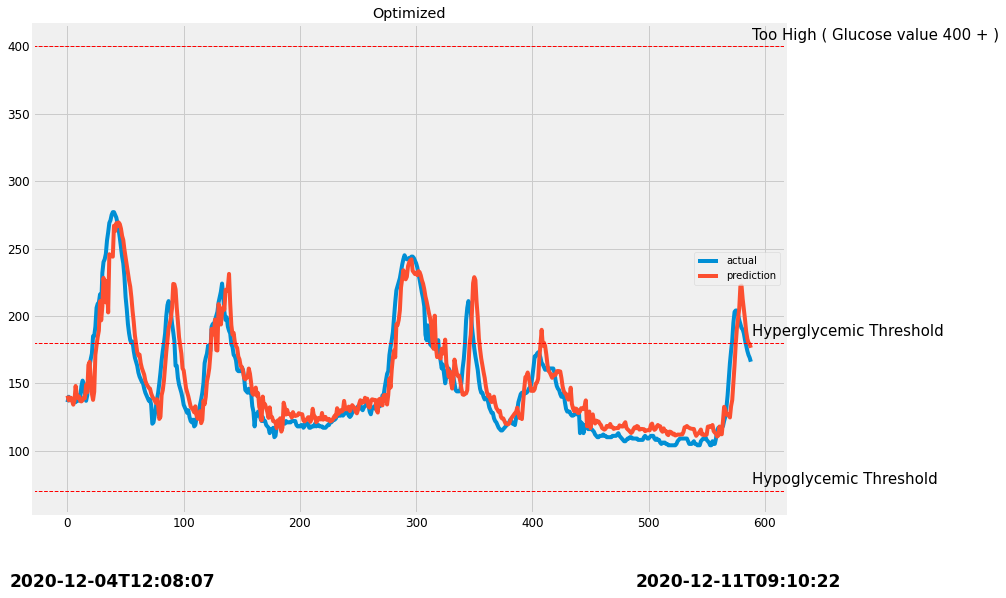

In [411]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

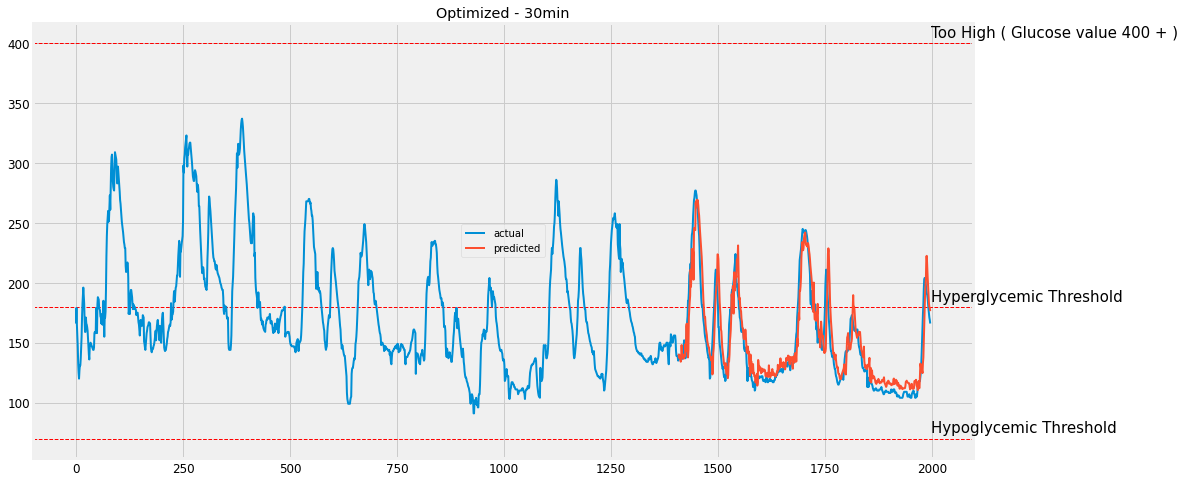

In [412]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 30min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

#### GA_Residual

Text(0.5, 1.0, '30Min GA Normal Q-Q Plot')

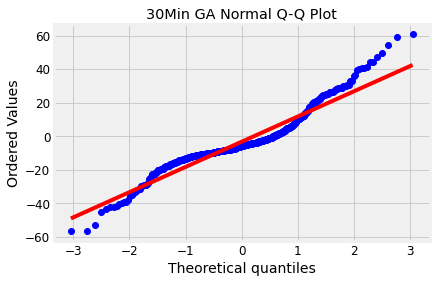

In [413]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("30Min GA Normal Q-Q Plot")

Text(0.5, 1.0, '30Min GA Normal Q-Q Plot')

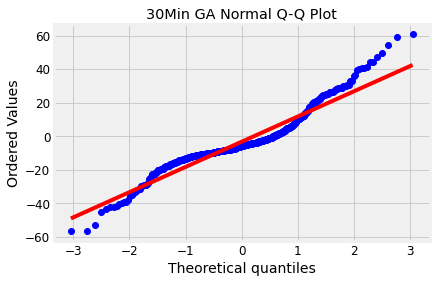

In [414]:
probplot(residuals,dist="norm",plot=plt)
plt.title("30Min GA Normal Q-Q Plot")

In [415]:
residuals=DataFrame(residuals)

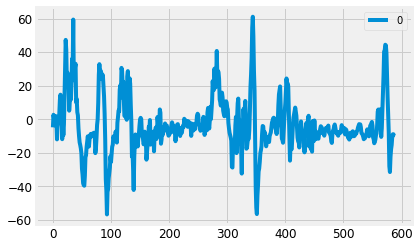

In [416]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbf6b12bd0>]],
      dtype=object)

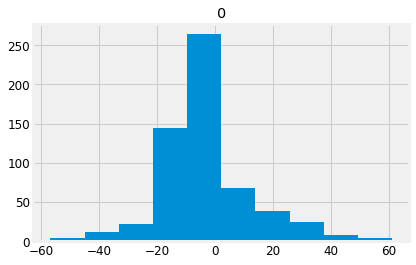

In [417]:

residuals.hist()

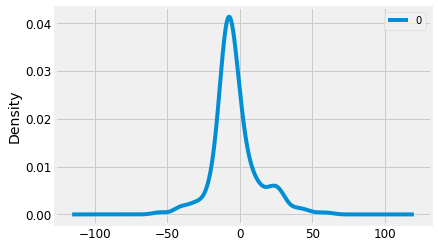

In [418]:
residuals.plot(kind='kde')

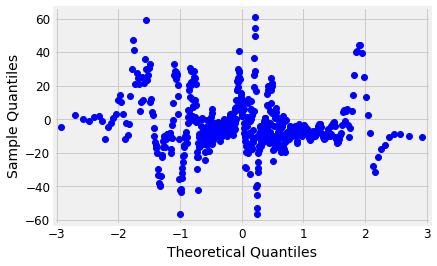

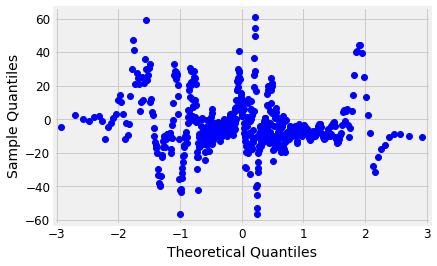

In [419]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [420]:
model2.output_dict

{'function': -31.237868598683676,
 'last_generation': {'scores': array([-31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.2378686 , -31.2378686 ,
         -31.2378686 , -31.2378686 , -31.23750894, -31.23750894,
         -31.23750894, -31.23750894, -31.23750894, -31.23707053,
         -31.23682464, -31.23682464, -31.23682464, -31.23682464,
         -31.23682464, -31.23682464, -31.23682464, -31.23682464,
         -31.23682464, -31.23682464, -31.2360257 , -31.2360257 ,
         -31.2360257 , -31.

In [421]:
#model2.output_dict['variable'][0]


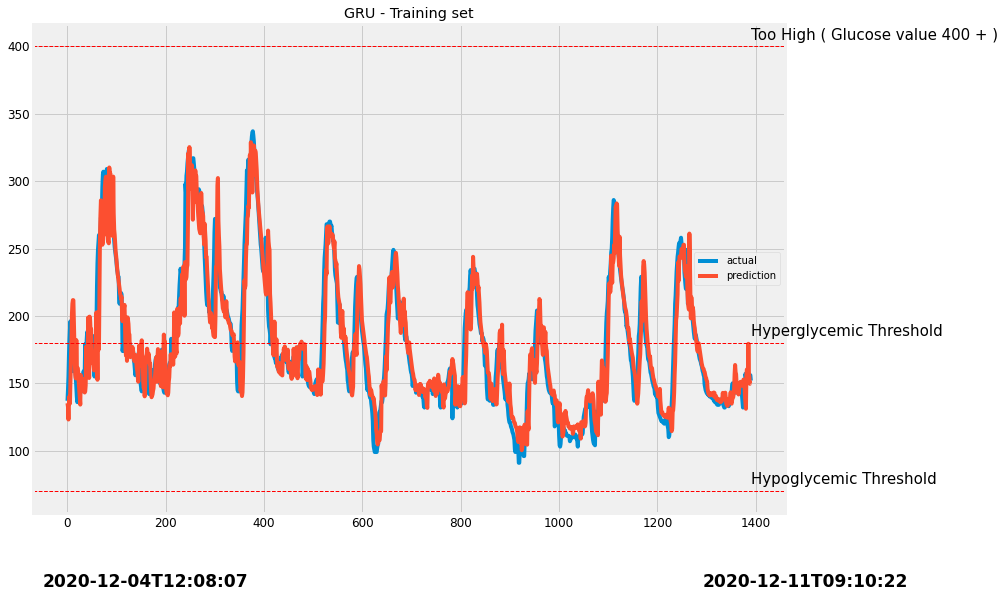

In [422]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [423]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [424]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=11
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [425]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [426]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [427]:
x_train_uni[0]

array([[166],
       [179],
       [165],
       [157],
       [147],
       [133]])

In [428]:
y_train_uni[0]

196

In [429]:
df['Glucose'].head(20)

0     166.0
1     179.0
2     165.0
3     157.0
4     147.0
5     133.0
6     125.0
7     120.0
8     127.0
9     131.0
10    131.0
11    137.0
12    145.0
13    155.0
14    171.0
15    182.0
16    190.0
17    196.0
18    190.0
19    183.0
Name: Glucose, dtype: float64

### RNN - 60분

In [430]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [431]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:])) # recurrent_dropout=0.2
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()

In [432]:
val_rnn_60_predict_result = model.predict(x_val_uni,verbose=0)

In [433]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)
val_rnn_60_predict_result=predict_result

 Vanila RNN (Simple RNN) - RMSE (15min) :  27.981513040624147


In [434]:
get_x_train_origin_60 = np.array(y_train_uni_origin)

In [435]:
get_x_train_origin_60 = get_x_train_origin_60.reshape(1,len(y_train_uni_origin))

In [436]:
get_x_train_origin_60.shape

(1, 1391)

In [437]:
get_y_val_origin_60 = np.array(y_val_uni_origin)

In [438]:
get_y_val_origin_60 = get_y_val_origin_60.reshape(1,len(get_y_val_origin_60))

In [439]:
get_y_val_origin_60.shape

(1, 583)

In [440]:
#get_y_val_origin

In [441]:
get_val_rnn_60_predict_result = np.array(val_rnn_60_predict_result)

In [442]:
get_val_rnn_60_predict_result = get_val_rnn_60_predict_result.T

In [443]:
get_val_rnn_60_predict_result.shape

(1, 583)

In [444]:
predict_result

array([[137.02303 ],
       [134.60675 ],
       [138.29016 ],
       [143.31392 ],
       [142.55238 ],
       [138.65715 ],
       [143.15161 ],
       [153.14316 ],
       [150.83185 ],
       [146.03127 ],
       [146.26378 ],
       [143.35732 ],
       [142.91891 ],
       [144.10767 ],
       [147.26006 ],
       [146.73006 ],
       [155.27007 ],
       [151.7639  ],
       [166.9093  ],
       [172.52055 ],
       [164.01001 ],
       [141.91216 ],
       [136.56044 ],
       [145.81119 ],
       [176.62787 ],
       [194.96959 ],
       [195.9813  ],
       [193.12083 ],
       [212.5771  ],
       [202.87007 ],
       [206.12622 ],
       [224.99757 ],
       [226.45071 ],
       [210.80443 ],
       [216.19728 ],
       [194.18509 ],
       [236.15369 ],
       [246.20703 ],
       [244.58931 ],
       [236.49838 ],
       [256.62952 ],
       [250.08513 ],
       [252.74327 ],
       [249.01245 ],
       [251.69421 ],
       [247.89105 ],
       [245.5104  ],
       [241.0

In [445]:
y_val_uni_origin

array([136, 136, 137, 137, 141, 140, 148, 152, 150, 142, 137, 141, 154,
       163, 168, 172, 185, 185, 192, 206, 209, 210, 216, 207, 232, 240,
       242, 246, 256, 262, 269, 271, 275, 277, 277, 275, 273, 269, 264,
       258, 251, 244, 239, 229, 214, 205, 194, 187, 182, 180, 181, 174,
       169, 166, 163, 158, 155, 153, 151, 150, 146, 143, 141, 139, 137,
       138, 134, 120, 121, 126, 132, 138, 143, 150, 158, 167, 174, 180,
       187, 200, 208, 211, 208, 202, 194, 188, 181, 163, 163, 154, 149,
       146, 143, 139, 134, 132, 130, 128, 130, 125, 122, 121, 123, 118,
       119, 124, 125, 129, 134, 138, 143, 150, 165, 169, 172, 178, 173,
       174, 192, 194, 194, 197, 200, 203, 210, 214, 218, 224, 215, 203,
       197, 199, 192, 189, 187, 179, 177, 171, 170, 167, 160, 159, 159,
       159, 162, 160, 154, 145, 144, 143, 146, 143, 143, 133, 129, 118,
       127, 126, 129, 128, 124, 122, 125, 122, 122, 119, 118, 117, 113,
       116, 115, 117, 110, 111, 118, 120, 120, 121, 120, 121, 12

#### 잔차

In [446]:
y_val_uni_origin

array([136, 136, 137, 137, 141, 140, 148, 152, 150, 142, 137, 141, 154,
       163, 168, 172, 185, 185, 192, 206, 209, 210, 216, 207, 232, 240,
       242, 246, 256, 262, 269, 271, 275, 277, 277, 275, 273, 269, 264,
       258, 251, 244, 239, 229, 214, 205, 194, 187, 182, 180, 181, 174,
       169, 166, 163, 158, 155, 153, 151, 150, 146, 143, 141, 139, 137,
       138, 134, 120, 121, 126, 132, 138, 143, 150, 158, 167, 174, 180,
       187, 200, 208, 211, 208, 202, 194, 188, 181, 163, 163, 154, 149,
       146, 143, 139, 134, 132, 130, 128, 130, 125, 122, 121, 123, 118,
       119, 124, 125, 129, 134, 138, 143, 150, 165, 169, 172, 178, 173,
       174, 192, 194, 194, 197, 200, 203, 210, 214, 218, 224, 215, 203,
       197, 199, 192, 189, 187, 179, 177, 171, 170, 167, 160, 159, 159,
       159, 162, 160, 154, 145, 144, 143, 146, 143, 143, 133, 129, 118,
       127, 126, 129, 128, 124, 122, 125, 122, 122, 119, 118, 117, 113,
       116, 115, 117, 110, 111, 118, 120, 120, 121, 120, 121, 12

In [447]:
val_rnn_60_predict_result

array([[137.02303 ],
       [134.60675 ],
       [138.29016 ],
       [143.31392 ],
       [142.55238 ],
       [138.65715 ],
       [143.15161 ],
       [153.14316 ],
       [150.83185 ],
       [146.03127 ],
       [146.26378 ],
       [143.35732 ],
       [142.91891 ],
       [144.10767 ],
       [147.26006 ],
       [146.73006 ],
       [155.27007 ],
       [151.7639  ],
       [166.9093  ],
       [172.52055 ],
       [164.01001 ],
       [141.91216 ],
       [136.56044 ],
       [145.81119 ],
       [176.62787 ],
       [194.96959 ],
       [195.9813  ],
       [193.12083 ],
       [212.5771  ],
       [202.87007 ],
       [206.12622 ],
       [224.99757 ],
       [226.45071 ],
       [210.80443 ],
       [216.19728 ],
       [194.18509 ],
       [236.15369 ],
       [246.20703 ],
       [244.58931 ],
       [236.49838 ],
       [256.62952 ],
       [250.08513 ],
       [252.74327 ],
       [249.01245 ],
       [251.69421 ],
       [247.89105 ],
       [245.5104  ],
       [241.0

In [448]:
#zone_accuracy(y_val_uni_origin,val_rnn_60_predict_result,mode='clarke',detailed=False,diabetes_type=2)

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

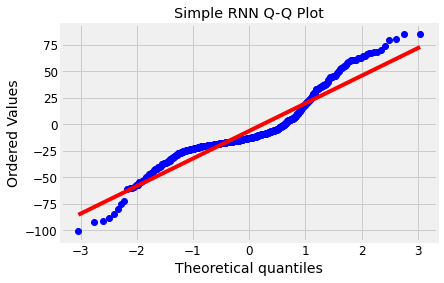

In [449]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(val_rnn_60_predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

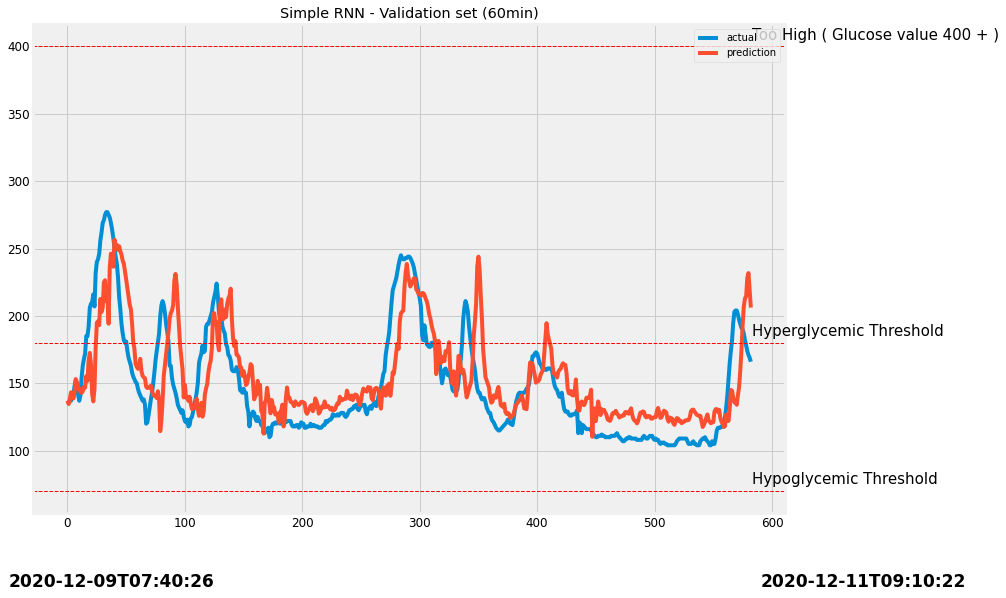

In [450]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

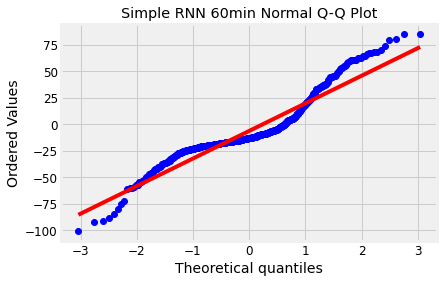

In [451]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [452]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400    
    if predict_result[i] <= 60: 
        predict_result[i]=60          
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)
train_rnn_60_predict_result=predict_result

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  30.245114369138822


In [453]:
y_train_uni_origin

array([196, 190, 183, ..., 139, 138, 135])

In [454]:
predict_result

array([[122.90387],
       [114.15169],
       [115.48409],
       ...,
       [150.88306],
       [154.08667],
       [154.16345]], dtype=float32)

In [455]:
get_train_rnn_60_predict_result = np.array(train_rnn_60_predict_result)

In [456]:
get_train_rnn_60_predict_result = get_train_rnn_60_predict_result.T

In [457]:
get_train_rnn_60_predict_result.shape

(1, 1391)

#### Train

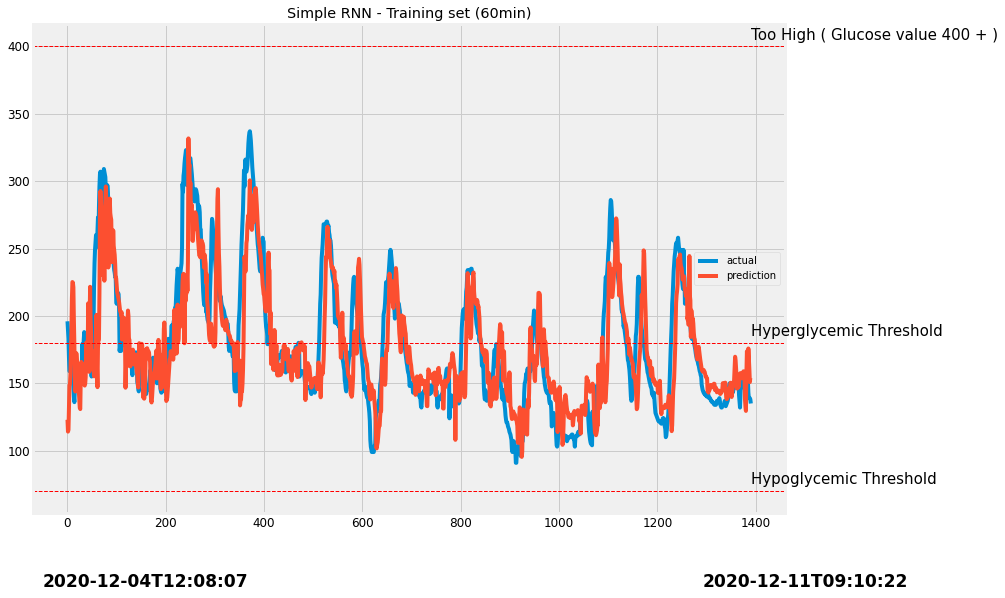

In [458]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [459]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [460]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))  #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_lstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [461]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    elif predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)
val_lstm_60_predict_result=predict_result

 LSTM - RMSE (60min) :  27.688865733122142


In [462]:
get_val_lstm_60_predict_result = np.array(val_lstm_60_predict_result)

In [463]:
get_val_lstm_60_predict_result = get_val_lstm_60_predict_result.T

In [464]:
get_val_lstm_60_predict_result.shape

(1, 583)

In [465]:
predict_result

array([[145.87018 ],
       [141.93225 ],
       [139.8453  ],
       [142.02211 ],
       [143.14417 ],
       [141.89761 ],
       [142.93802 ],
       [148.9566  ],
       [147.30644 ],
       [145.75212 ],
       [145.80643 ],
       [143.19106 ],
       [142.81882 ],
       [143.0684  ],
       [144.6988  ],
       [144.90364 ],
       [152.58344 ],
       [149.20447 ],
       [167.22227 ],
       [172.80568 ],
       [160.26767 ],
       [150.76456 ],
       [147.92802 ],
       [144.98866 ],
       [170.40901 ],
       [195.68845 ],
       [203.32288 ],
       [193.96484 ],
       [215.96503 ],
       [201.0991  ],
       [204.16837 ],
       [218.17691 ],
       [220.35999 ],
       [210.72578 ],
       [214.91074 ],
       [186.6148  ],
       [236.75116 ],
       [247.15797 ],
       [246.71404 ],
       [239.00653 ],
       [256.16425 ],
       [253.67099 ],
       [260.44324 ],
       [249.91168 ],
       [248.68185 ],
       [244.93553 ],
       [242.45746 ],
       [240.5

#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

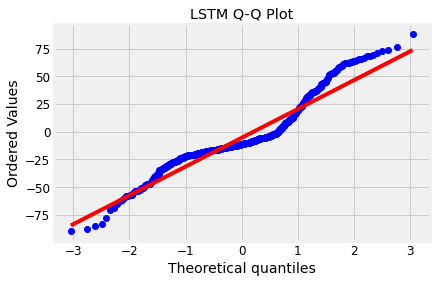

In [466]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

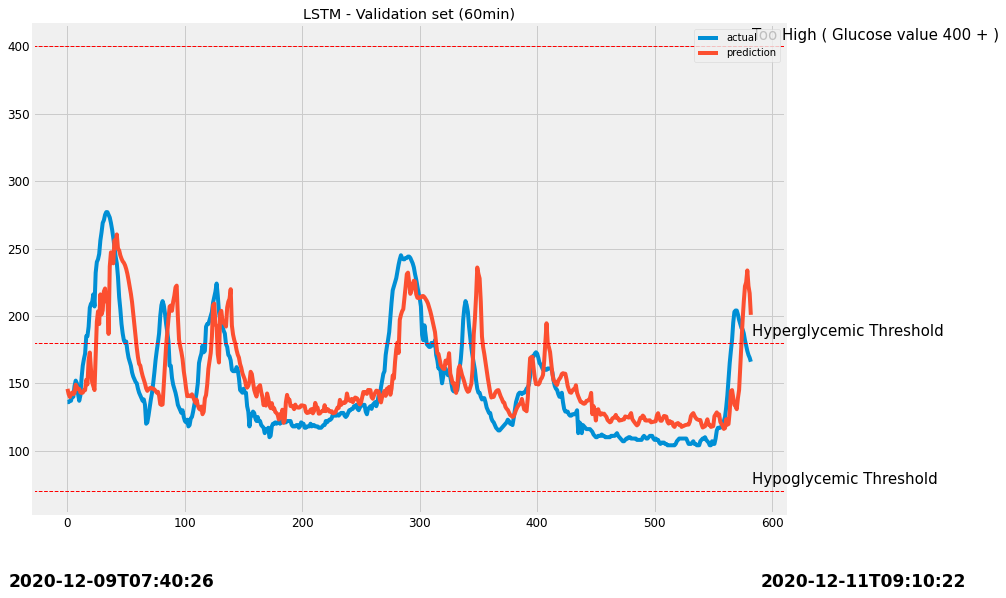

In [467]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [468]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)
train_lstm_60_predict_result=predict_result

 LSTM - RMSE (60min) Training set :  30.472966238142327


In [469]:
get_train_lstm_60_predict_result = np.array(train_lstm_60_predict_result)

In [470]:
get_train_lstm_60_predict_result = get_train_lstm_60_predict_result.T

In [471]:
get_train_lstm_60_predict_result.shape

(1, 1391)

#### Train

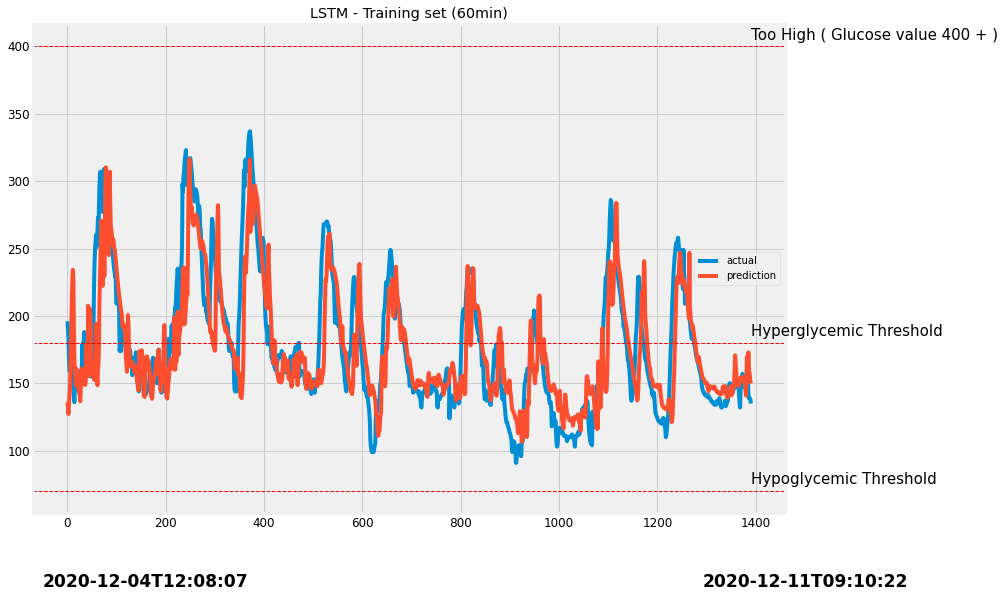

In [472]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [473]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [474]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:])) # recurrent_dropout=0.2
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [475]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

In [476]:
val_slstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [477]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)
val_slstm_60_predict_result=predict_result

 Stacked LSTM - RMSE(15min) :  28.212337588399595


In [478]:
predict_result

array([[143.29349 ],
       [146.11635 ],
       [150.38052 ],
       [146.88666 ],
       [143.06412 ],
       [139.16435 ],
       [144.36487 ],
       [151.13263 ],
       [145.81177 ],
       [144.8142  ],
       [145.96907 ],
       [141.98943 ],
       [143.12152 ],
       [143.3081  ],
       [145.41833 ],
       [144.63702 ],
       [153.21167 ],
       [147.81885 ],
       [167.72603 ],
       [170.3136  ],
       [159.4709  ],
       [142.7953  ],
       [140.49255 ],
       [154.90144 ],
       [171.33614 ],
       [182.85617 ],
       [204.04613 ],
       [210.41623 ],
       [225.25935 ],
       [199.24179 ],
       [203.23842 ],
       [219.86209 ],
       [217.60214 ],
       [209.15395 ],
       [216.74998 ],
       [187.43318 ],
       [240.82901 ],
       [246.52579 ],
       [242.87296 ],
       [242.85944 ],
       [260.31586 ],
       [253.94133 ],
       [260.84735 ],
       [254.72139 ],
       [254.57399 ],
       [247.31412 ],
       [241.00865 ],
       [236.2

In [479]:
get_val_slstm_60_predict_result = np.array(val_slstm_60_predict_result)

In [480]:
get_val_slstm_60_predict_result = get_val_slstm_60_predict_result.T

In [481]:
get_val_slstm_60_predict_result.shape

(1, 583)

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

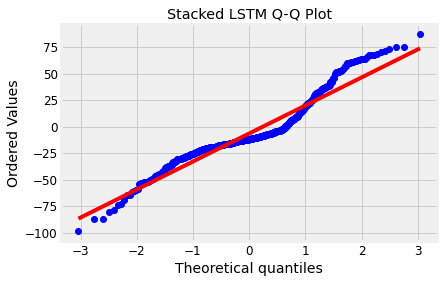

In [482]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

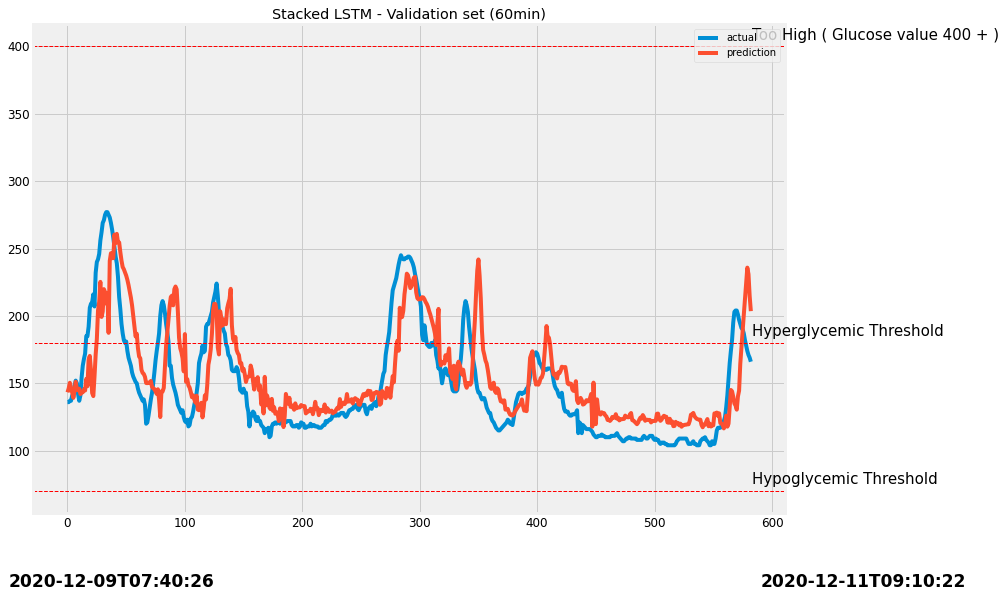

In [483]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [484]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)
train_slstm_60_predict_result=predict_result

 Training set / STACKED LSTM - RMSE (60min) Training set :  30.035655954536967


In [485]:
get_train_slstm_60_predict_result = np.array(train_slstm_60_predict_result)

In [486]:
get_train_slstm_60_predict_result = get_train_slstm_60_predict_result.T

In [487]:
get_train_slstm_60_predict_result.shape

(1, 1391)

#### Train

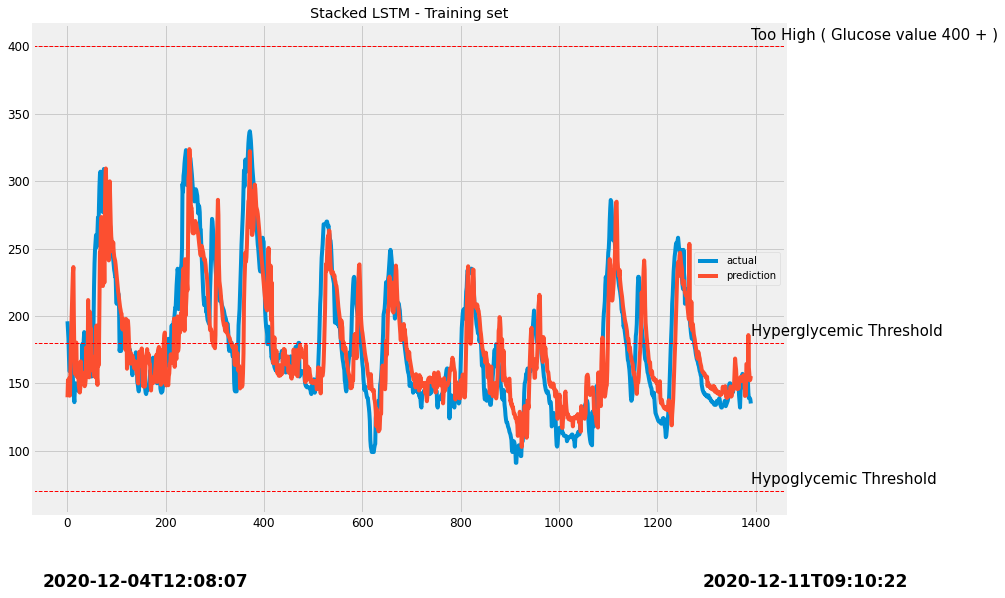

In [488]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [489]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [490]:
from keras.layers import Bidirectional
from tensorflow.keras import layers
model = Sequential()

model.add(Bidirectional(LSTM(50,activation='relu',return_sequences=True),input_shape=x_train_uni.shape[-2:]))
model.add(Bidirectional(layers.LSTM(50,activation='relu')))
#model.add(Bidirectional(forward_layer,backward_layer=backward_layer,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [491]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_bilstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [492]:
predict_result.shape

(1391, 1)

In [493]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    if predict_result[i] <= 60: 
        predict_result[i]=60

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)
val_bilstm_60_predict_result = predict_result

Bidirectional LSTM - RMSE :  28.13699534654827


In [494]:
get_val_bilstm_60_predict_result = np.array(val_bilstm_60_predict_result)

In [495]:
get_val_bilstm_60_predict_result = get_val_bilstm_60_predict_result.T

In [496]:
get_val_bilstm_60_predict_result.shape

(1, 583)

In [497]:
predict_result

array([[143.00876 ],
       [141.87749 ],
       [142.2087  ],
       [141.3887  ],
       [140.03983 ],
       [138.33136 ],
       [140.51624 ],
       [146.23727 ],
       [143.53421 ],
       [141.41602 ],
       [142.58632 ],
       [140.2219  ],
       [140.03113 ],
       [140.382   ],
       [141.65218 ],
       [141.46417 ],
       [148.54646 ],
       [145.73973 ],
       [161.31273 ],
       [171.96338 ],
       [155.98738 ],
       [142.31105 ],
       [140.57909 ],
       [144.70041 ],
       [171.98744 ],
       [188.66663 ],
       [190.52217 ],
       [192.62956 ],
       [216.23927 ],
       [201.74779 ],
       [195.2874  ],
       [229.39987 ],
       [221.63489 ],
       [199.78136 ],
       [208.31859 ],
       [184.72958 ],
       [249.89235 ],
       [255.57816 ],
       [225.32263 ],
       [226.51768 ],
       [246.53856 ],
       [242.03986 ],
       [244.76122 ],
       [242.591   ],
       [242.70831 ],
       [236.84225 ],
       [232.69179 ],
       [230.3

#### Validation

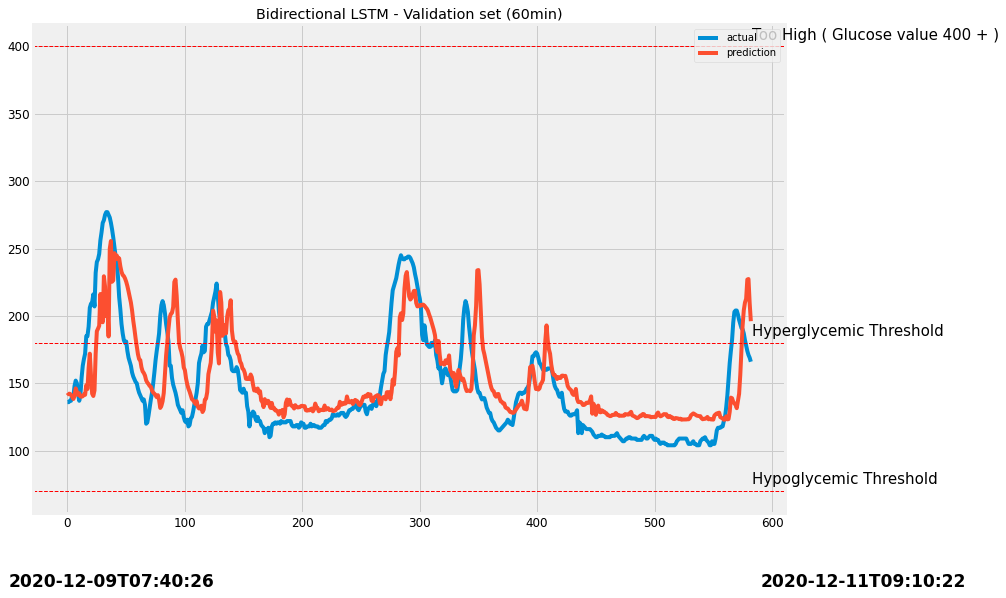

In [498]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

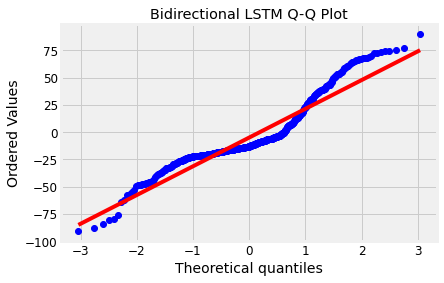

In [499]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [500]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)
train_bilstm_60_predict_result=predict_result

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  30.839780596810698


In [501]:
get_train_bilstm_60_predict_result = np.array(train_bilstm_60_predict_result)

In [502]:
get_train_bilstm_60_predict_result = get_train_bilstm_60_predict_result.T

In [503]:
get_train_bilstm_60_predict_result.shape

(1, 1391)

#### Train

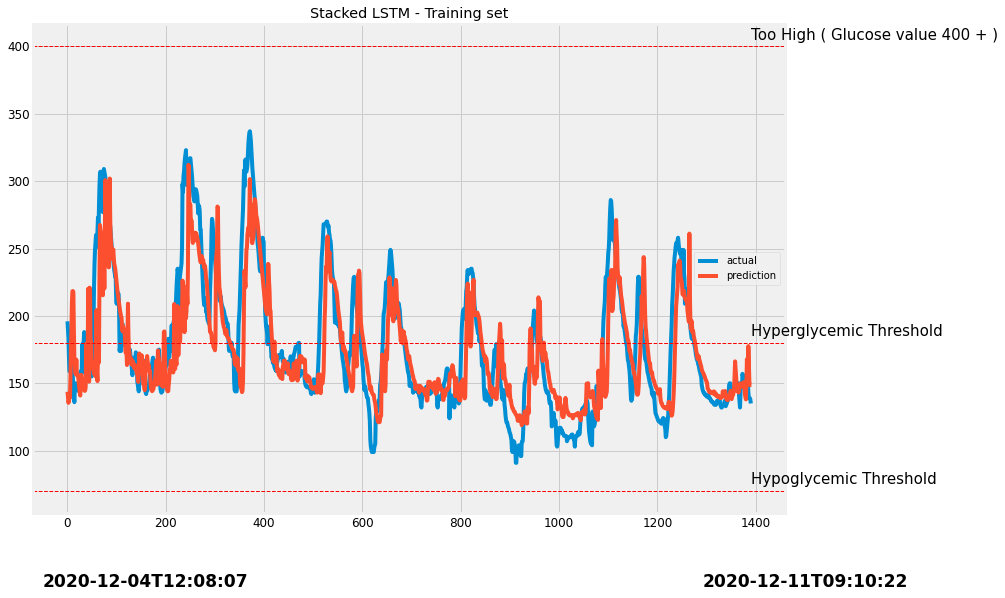

In [504]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [505]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [506]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [507]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [508]:
val_gru_60_predict_result = model.predict(x_val_uni,verbose=0)
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
    if predict_result[i] <= 60: 
        predict_result[i]=60

#predict_result

#predict_result


print('GRU - RMSE 60min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63
val_gru_60_predict_result=predict_result

GRU - RMSE 60min :  27.58346940825705


In [509]:
get_val_gru_60_predict_result = np.array(val_gru_60_predict_result)

In [510]:
get_val_gru_60_predict_result = get_val_gru_60_predict_result.T

In [511]:
get_val_gru_60_predict_result.shape

(1, 583)

In [512]:
predict_result

array([[144.24991 ],
       [141.56224 ],
       [141.79395 ],
       [142.12283 ],
       [141.38611 ],
       [139.44745 ],
       [142.0619  ],
       [151.04259 ],
       [146.18376 ],
       [145.29431 ],
       [146.9428  ],
       [141.33214 ],
       [141.51164 ],
       [142.25764 ],
       [144.32626 ],
       [144.81639 ],
       [156.43001 ],
       [149.35542 ],
       [174.36276 ],
       [172.21935 ],
       [158.43391 ],
       [147.37254 ],
       [141.12    ],
       [144.47609 ],
       [172.56609 ],
       [185.43597 ],
       [192.82541 ],
       [196.26736 ],
       [228.84908 ],
       [200.44307 ],
       [197.68452 ],
       [239.19371 ],
       [215.65399 ],
       [204.94452 ],
       [230.54709 ],
       [201.28499 ],
       [239.0212  ],
       [236.84467 ],
       [235.03485 ],
       [251.13829 ],
       [269.59476 ],
       [246.9153  ],
       [258.273   ],
       [254.09807 ],
       [257.54852 ],
       [250.80594 ],
       [245.96501 ],
       [240.0

#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

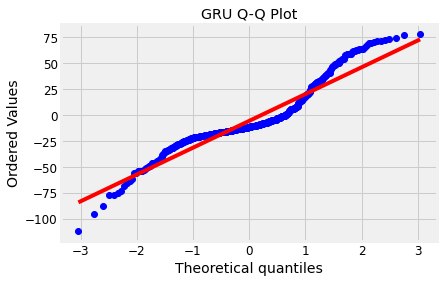

In [513]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

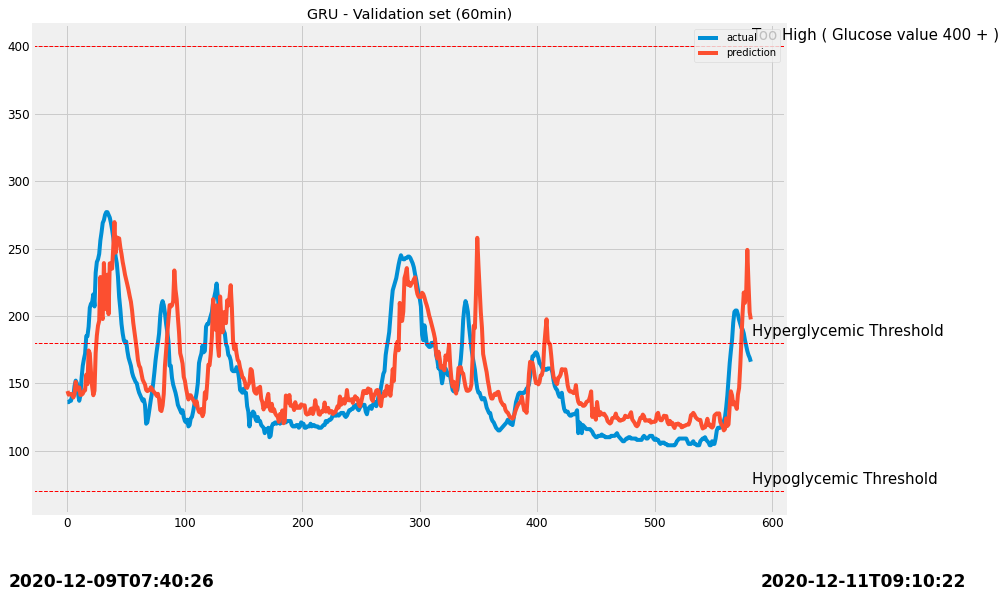

In [514]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [515]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

    if predict_result[i] <= 60: 
        predict_result[i]=60
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)
train_gru_60_predict_result=predict_result

 Training set / GRU - RMSE (60min) Training set :  29.40546160777775


In [516]:
get_train_gru_60_predict_result = np.array(train_gru_60_predict_result)

In [517]:
get_train_gru_60_predict_result = get_train_gru_60_predict_result.T

In [518]:
get_train_gru_60_predict_result.shape

(1, 1391)

#### Train

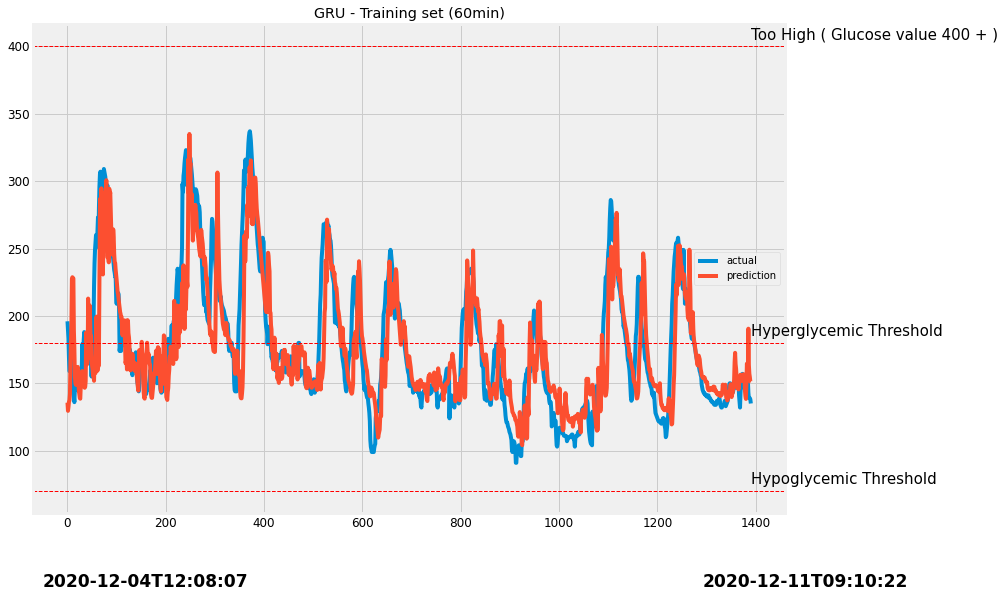

In [519]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GA

In [520]:
val_rnn_60_predict_result = np.asarray(val_rnn_60_predict_result)
val_lstm_60_predict_result = np.asarray(val_lstm_60_predict_result)
val_slstm_60_predict_result = np.asarray(val_slstm_60_predict_result)
val_bilstm_60_predict_result = np.asarray(val_bilstm_60_predict_result)
val_gru_60_predict_result = np.asarray(val_gru_60_predict_result)

In [521]:
train_rnn_60_predict_result = np.asarray(train_rnn_60_predict_result)
train_lstm_60_predict_result = np.asarray(train_lstm_60_predict_result)
train_slstm_60_predict_result = np.asarray(train_slstm_60_predict_result)
train_bilstm_60_predict_result = np.asarray(train_bilstm_60_predict_result)
train_gru_60_predict_result = np.asarray(train_gru_60_predict_result)

In [522]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 100 - np.sqrt(mean_squared_error(train_rnn_60_predict_result * X[0] + train_lstm_60_predict_result * X[1] +train_slstm_60_predict_result * X[2] + 
                                train_bilstm_60_predict_result * X[3] + train_gru_60_predict_result * X[4],y_train_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [523]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [524]:
algorithm_param = {'max_num_iteration': 10000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [525]:
model3 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40008527386641

 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40008527386641

 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40008527386641

 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40008527386641

 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40008527386641

 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40008527386641

 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40008527386641

 ** B ** 

[0.09478143 0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40426033935802

 ** B ** 

[0.09478143 0.05175942 0.30960675 0.05413954 0.48971279]

 ** C ** 

70.40426033935802

 ** B ** 

[0.0945238  0.05175942 0.30960675 0.05413954 0.48971279]

 ** 

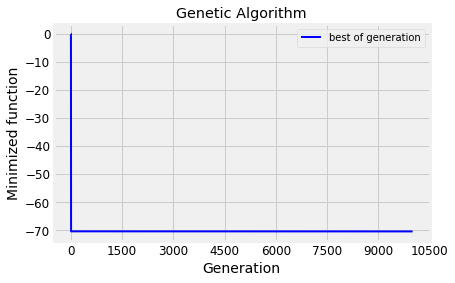

In [526]:
model3.run()

In [527]:
# RMSE 
optimized = val_rnn_60_predict_result * model3.output_dict['variable'][0] + val_lstm_60_predict_result *model3.output_dict['variable'][1] + val_slstm_60_predict_result * model3.output_dict['variable'][2] + val_bilstm_60_predict_result * model3.output_dict['variable'][3] + val_gru_60_predict_result * model3.output_dict['variable'][4]
for i in range(len(optimized)):
    if optimized[i] >= 400: 
        optimized[i]=400
    if optimized[i] <= 60: 
        optimized[i]=60
optimized_rmse_60 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_60

27.714586701371626

In [528]:
optimized

array([[143.28549 ],
       [142.34918 ],
       [144.0419  ],
       [143.66568 ],
       [142.03427 ],
       [139.35129 ],
       [142.83986 ],
       [150.90143 ],
       [146.4238  ],
       [145.02924 ],
       [146.28229 ],
       [141.7637  ],
       [142.13095 ],
       [142.69864 ],
       [144.81696 ],
       [144.76526 ],
       [154.69772 ],
       [148.90439 ],
       [170.52542 ],
       [171.67435 ],
       [159.24594 ],
       [145.33939 ],
       [140.81665 ],
       [147.86906 ],
       [172.42728 ],
       [186.24643 ],
       [197.01717 ],
       [200.03357 ],
       [224.84583 ],
       [200.40576 ],
       [200.40997 ],
       [230.24492 ],
       [217.84785 ],
       [206.82289 ],
       [222.90254 ],
       [194.6678  ],
       [239.78018 ],
       [242.2774  ],
       [238.44585 ],
       [245.22662 ],
       [263.54968 ],
       [249.47675 ],
       [257.92673 ],
       [252.96935 ],
       [254.81033 ],
       [248.38872 ],
       [243.48723 ],
       [238.4

In [529]:
get_optimized = np.array(optimized)

In [530]:
get_optimized = get_optimized.T

In [531]:
get_optimized.shape

(1, 583)

In [532]:
ar_val_60=np.concatenate((get_y_val_origin_60, get_val_rnn_60_predict_result,get_val_lstm_60_predict_result,get_val_slstm_60_predict_result,get_val_bilstm_60_predict_result,get_val_gru_60_predict_result,get_optimized), axis = 0)


In [533]:
ar_train_60 = np.concatenate((get_x_train_origin_60, get_train_rnn_60_predict_result ,get_train_lstm_60_predict_result ,get_train_slstm_60_predict_result,get_train_bilstm_60_predict_result,get_train_gru_60_predict_result),axis=0)

In [534]:
#ar_val_15=np.concatenate((get_y_val_origin, get_val_rnn_15_predict_result,get_val_lstm_15_predict_result,get_val_slstm_15_predict_result,get_val_bilstm_15_predict_result,get_val_gru_15_predict_result), axis = 0)


In [535]:
#ar_train_15 = np.concatenate((get_x_train_origin_15, get_train_rnn_15_predict_result ,get_train_lstm_15_predict_result ,get_train_slstm_15_predict_result,get_train_bilstm_15_predict_result,get_train_gru_15_predict_result),axis=0)

In [536]:
y1=pd.DataFrame(ar_val_60,index=['60_val_origin','60_val_rnn','60_val_lstm','60_val_slstm','60_val_bilstm','60_val_gru','60_optimized'])
y1

0           1           2           3           4    \
60_val_origin  136.000000  136.000000  137.000000  137.000000  141.000000   
60_val_rnn     137.023026  134.606750  138.290161  143.313919  142.552383   
60_val_lstm    145.870178  141.932251  139.845306  142.022110  143.144165   
60_val_slstm   143.293488  146.116348  150.380524  146.886658  143.064117   
60_val_bilstm  143.008759  141.877487  142.208694  141.388702  140.039825   
60_val_gru     144.249908  141.562241  141.793945  142.122833  141.386108   
60_optimized   143.285492  142.349182  144.041901  143.665680  142.034271   

                      5           6           7           8           9    \
60_val_origin  140.000000  148.000000  152.000000  150.000000  142.000000   
60_val_rnn     138.657150  143.151611  153.143158  150.831848  146.031265   
60_val_lstm    141.897614  142.938019  148.956604  147.306442  145.752121   
60_val_slstm   139.164352  144.364868  151.132629  145.811768  144.814194   
60_val_bilstm  138.331360  140.516235  146.237274  143.534210  141.416016   
60_val_gru     139.447449  142.061905  151.042587  146.183762  145.294312   
60_optimized   139.351288  142.839859  150.901428  146.423798  145.029236   

                      10          11          12          13          14   \
60_val_origin  137.000000  141.000000  154.000000  163.000000  168.000000   
60_val_rnn     146.263779  143.357315  142.918915  144.107666  147.260056   
60_val_lstm    145.806427  143.191055  142.818817  143.068405  144.698807   
60_val_slstm   145.969070  141.989426  143.121521  143.308105  145.418335   
60_val_bilstm  142.586319  140.221893  140.031128  140.382004  141.652176   
60_val_gru     146.942795  141.332138  141.511642  142.257645  144.326263   
60_optimized   146.282288  141.763702  142.130951  142.698639  144.816956   

                      15          16          17          18          19   \
60_val_origin  172.000000  185.000000  185.000000  192.000000  206.000000   
60_val_rnn     146.730057  155.270065  151.763901  166.909302  172.520554   
60_val_lstm    144.903641  152.583435  149.204468  167.222275  172.805679   
60_val_slstm   144.637024  153.211670  147.818848  167.726028  170.313599   
60_val_bilstm  141.464172  148.546463  145.739731  161.312729  171.963379   
60_val_gru     144.816391  156.430008  149.355423  174.362762  172.219345   
60_optimized   144.765259  154.697723  148.904388  170.525421  171.674347   

                      20          21          22          23          24   \
60_val_origin  209.000000  210.000000  216.000000  207.000000  232.000000   
60_val_rnn     164.010010  141.912155  136.560440  145.811188  176.627869   
60_val_lstm    160.267670  150.764557  147.928024  144.988663  170.409012   
60_val_slstm   159.470901  142.795303  140.492554  154.901443  171.336136   
60_val_bilstm  155.987381  142.311050  140.579086  144.700409  171.987442   
60_val_gru     158.433914  147.372543  141.119995  144.476089  172.566086   
60_optimized   159.245941  145.339386  140.816650  147.869064  172.427277   

                      25          26          27          28          29   \
60_val_origin  240.000000  242.000000  246.000000  256.000000  262.000000   
60_val_rnn     194.969589  195.981293  193.120834  212.577103  202.870071   
60_val_lstm    195.688446  203.322876  193.964844  215.965027  201.099106   
60_val_slstm   182.856171  204.046127  210.416229  225.259354  199.241791   
60_val_bilstm  188.666626  190.522171  192.629562  216.239273  201.747787   
60_val_gru     185.435974  192.825409  196.267365  228.849075  200.443069   
60_optimized   186.246429  197.017166  200.033569  224.845825  200.405762   

                      30          31          32          33          34   \
60_val_origin  269.000000  271.000000  275.000000  277.000000  277.000000   
60_val_rnn     206.126221  224.997574  226.450714  210.804428  216.197281   
60_val_lstm    204.168365  218.176910  220.359985  210.725784  214.910736   
60_val_slstm

In [537]:
y1.to_csv("/content/drive/MyDrive/uni_data_result/"+file_name+"_test_60.csv")

In [538]:
y2=pd.DataFrame(ar_train_30,index=['60_train_origin','60_train_rnn','60_train_lstm','60_train_slstm','60_train_bilstm','60_train_gru'])
y2
#y.append(get_val_rnn_15_predict_result,ignore_index=True)

0           1           2           3           4     \
60_train_origin  137.000000  145.000000  155.000000  171.000000  182.000000   
60_train_rnn     123.761169  117.117546  114.784622  130.909195  137.729477   
60_train_lstm    138.652939  141.048309  146.594040  148.906479  136.220032   
60_train_slstm   138.768875  136.375137  136.029633  152.398483  147.293167   
60_train_bilstm  136.658539  141.173004  131.826416  147.713730  136.601883   
60_train_gru     135.211227  132.515625  123.119919  134.950150  140.389938   

                       5           6           7           8           9     \
60_train_origin  190.000000  196.000000  190.000000  183.000000  169.000000   
60_train_rnn     140.690811  149.188324  163.021423  176.949463  194.542023   
60_train_lstm    138.707199  155.186066  170.077408  183.385605  198.357086   
60_train_slstm   134.948212  149.589828  166.913071  176.757095  191.708389   
60_train_bilstm  137.077103  151.186371  162.957016  175.635712  192.252747   
60_train_gru     134.974167  152.685364  168.440857  179.812439  200.984329   

                       10          11          12          13          14    \
60_train_origin  159.000000  159.000000  171.000000  166.000000  165.000000   
60_train_rnn     208.003738  213.377197  214.668640  197.151169  181.594086   
60_train_lstm    209.246521  218.852463  223.985016  195.739349  177.373703   
60_train_slstm   203.428024  212.067886  217.121353  188.386520  180.096451   
60_train_bilstm  204.622528  214.045105  218.295593  189.455353  175.589813   
60_train_gru     209.158325  211.728516  211.657364  196.304840  177.666290   

                       15          16          17          18          19    \
60_train_origin  163.000000  160.000000  154.000000  147.000000  140.000000   
60_train_rnn     158.038330  149.448975  153.478485  176.211533  167.116760   
60_train_lstm    167.452271  158.543900  159.892502  171.670349  161.133301   
60_train_slstm   165.876007  157.178055  160.622025  187.982147  162.225845   
60_train_bilstm  165.199219  157.620605  160.524567  174.173218  160.797958   
60_train_gru     163.814209  156.438782  153.599548  182.026306  162.736526   

                       20          21          22          23          24    \
60_train_origin  136.000000  146.000000  149.000000  150.000000  149.000000   
60_train_rnn     166.595993  162.141464  158.220047  146.928925  139.685196   
60_train_lstm    162.842972  160.476974  156.603653  151.342957  146.331894   
60_train_slstm   160.530914  159.204117  155.173264  146.435562  142.094986   
60_train_bilstm  161.729370  158.722687  154.823853  149.746704  144.876648   
60_train_gru     161.473602  161.135284  156.992432  149.752045  144.438461   

                       25          26          27          28          29    \
60_train_origin  148.000000  147.000000  146.000000  145.000000  144.000000   
60_train_rnn     132.926666  130.774292  150.548294  156.288574  158.953262   
60_train_lstm    141.007751  137.634735  154.063065  153.883942  157.658859   
60_train_slstm   137.439804  135.759521  164.534103  162.714005  151.101410   
60_train_bilstm  139.595490  136.908020  157.305878  152.449646  154.510132   
60_train_gru     138.479050  134.182312  156.189926  152.784958  153.759079   

                       30          31          32          33          34    \
60_train_origin  144.000000  146.000000  158.000000  159.000000  158.000000   
60_train_rnn     154.267456  152.770035  148.481384  146.508362  145.160919   
60_train_lstm    154.227783  150.162033  146.923416  145.459167  144.465927   
60_train_slstm   149.884262  150.700363  144.375122  142.582870  141.422150   
60_train_bilstm  151.466995  148.455963  145.265686  143.934067  143.008652   
60_train_gru     152.734772  152.735992  147.299713  145.310349  143.994171   

                       35          36          37          38          39    \
60_train_origin  158.000000  179.000000  165.000000  158.000000  1

In [539]:
y2.to_csv("/content/drive/MyDrive/uni_data_result/"+file_name+"_train_60.csv")

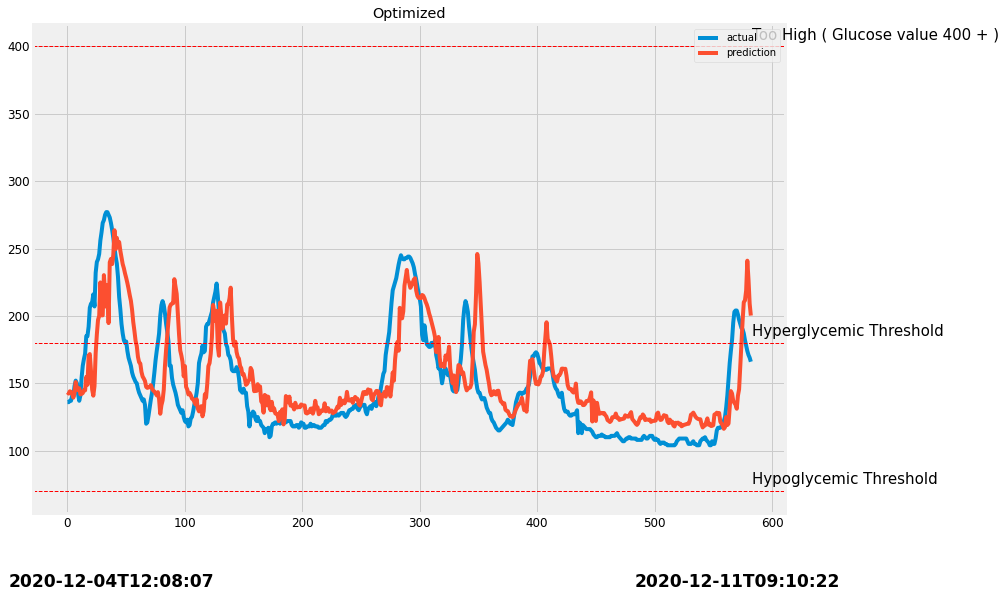

In [540]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

#### GA_Residual

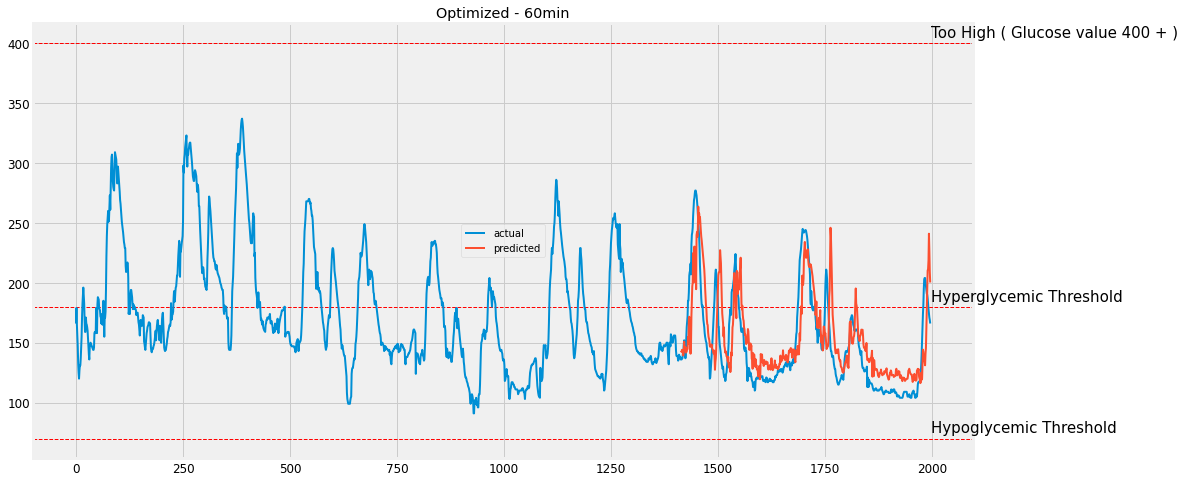

In [541]:
# Make a new dataframe of your prediction values
df_new = pd.DataFrame(df['Glucose'])
df_new.columns = ['rawseq']

# Retrieve index values
new_index = df_new['rawseq'].tail(len(optimized)).index

# Make a dataframe with your prediction values and your index
new_series = pd.DataFrame(index = new_index, data = optimized)

# Merge the dataframes
df_new = pd.merge(df_new, new_series, how = 'left', left_index=True, right_index=True)
df_new.columns = ['rawseq', 'optimized']

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)

plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(raw_seq),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(raw_seq),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized - 60min',family='Times New Roman')
plt.plot(df_new['rawseq'],label='actual',linewidth=2)
plt.plot(df_new['optimized'], label='predicted',linewidth=2)
plt.legend(loc='best')
plt.show()

Text(0.5, 1.0, '60Min GA Normal Q-Q Plot')

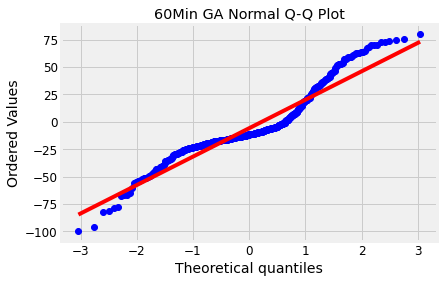

In [542]:
residuals = [y_val_uni_origin[i]-optimized[i] for i in range(len(optimized))]
residuals = y_val_uni_origin - optimized.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("60Min GA Normal Q-Q Plot")

Text(0.5, 1.0, '60Min GA Normal Q-Q Plot')

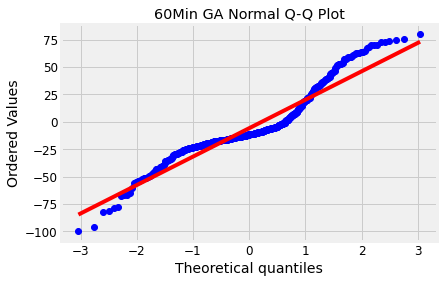

In [543]:
probplot(residuals,dist="norm",plot=plt)
plt.title("60Min GA Normal Q-Q Plot")

In [544]:
residuals=DataFrame(residuals)

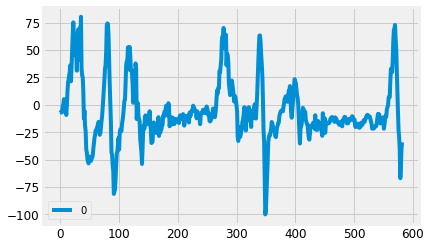

In [545]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbf5dd7150>]],
      dtype=object)

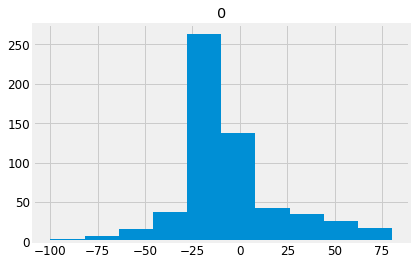

In [546]:

residuals.hist()

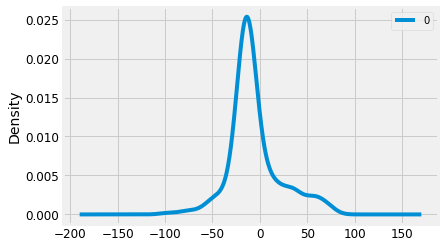

In [547]:
residuals.plot(kind='kde')

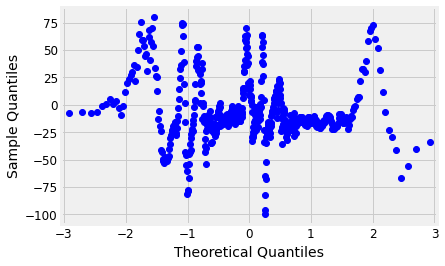

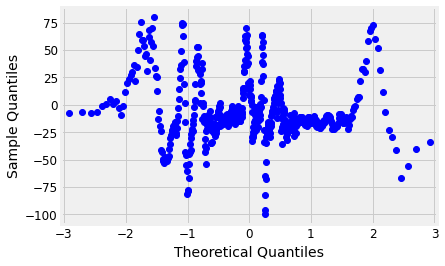

In [548]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## 결과

In [549]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15,optimized_rmse_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30,optimized_rmse_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60,optimized_rmse_60]


In [550]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]
val_optimized_result = [optimized_rmse_15,optimized_rmse_30,optimized_rmse_60]

In [551]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [552]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result,]

In [553]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result,val_optimized_result]

In [554]:
val_result_list

[[8.72, 16.454592819800865, 27.981513040624147],
 [9.19, 16.48789585678335, 27.688865733122142],
 [8.78, 15.819766940309778, 28.212337588399595],
 [8.97, 16.577921248475175, 28.13699534654827],
 [8.7, 16.027551632849637, 27.58346940825705],
 [8.712493818176446, 15.957753122770884, 27.714586701371626]]

In [555]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU','Optimized'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

15 MIN     30 MIN     60 MIN
RNN                 8.720000  16.454593  27.981513
LSTM                9.190000  16.487896  27.688866
Stacked LSTM        8.780000  15.819767  28.212338
Bidirectional LSTM  8.970000  16.577921  28.136995
GRU                 8.700000  16.027552  27.583469
Optimized           8.712494  15.957753  27.714587

In [556]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

15 MIN     30 MIN     60 MIN
RNN                  11.83  19.408517  30.245114
LSTM                 11.57  19.182174  30.472966
Stacked LSTM         11.24  19.012402  30.035656
Bidirectional LSTM   11.67  19.340228  30.839781
GRU                  11.48  18.788853  29.405462

## CNN LSTM